In [293]:
### Plot inline
%matplotlib inline
#'exec(%matplotlib inline)'
# Increase plotting resolution to vector format
%config InlineBackend.figure_format = 'svg'

from matplotlib.font_manager import FontProperties
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from IPython import display
import matplotlib.gridspec as gridspec
import sys

import math as math
import datetime
from datetime import timedelta
import os

print (sys.path)
import pandas as pd
#import seaborn as sns
import matplotlib.dates as dates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter, YearLocator
import keras
#from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
#from keras import models
#from keras import layers
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import models, layers
from keras.callbacks import EarlyStopping

from GetAveragedExBVertical import *
from magnetometer_utils import *

['/home/juanpablo/Maestría-PUCP/Temas Avanzados de Física Computacional', '/home/juanpablo/yes/lib/python37.zip', '/home/juanpablo/yes/lib/python3.7', '/home/juanpablo/yes/lib/python3.7/lib-dynload', '', '/home/juanpablo/.local/lib/python3.7/site-packages', '/home/juanpablo/yes/lib/python3.7/site-packages', '/home/juanpablo/yes/lib/python3.7/site-packages/sami2py-0.2.2-py3.7.egg', '/home/juanpablo/yes/lib/python3.7/site-packages/netCDF4-1.5.4-py3.7-linux-x86_64.egg', '/home/juanpablo/yes/lib/python3.7/site-packages/cftime-1.2.1-py3.7-linux-x86_64.egg', '/home/juanpablo/yes/lib/python3.7/site-packages/pyIGRF-0.3.3-py3.7.egg', '/home/juanpablo/yes/lib/python3.7/site-packages/IPython/extensions', '/home/juanpablo/.ipython']


In [294]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [295]:
def getDatetime(year, month, day, LT):
    #year = 2002
    #month = 1
    #day = 5
    #LT = 10.042 
    sec = 3600*LT
    res = LT - int(LT)
    res_sec = res*3600 
    mins = int(res_sec//60)
    secs = int(res_sec%60)
    LT = int(LT)
    time = datetime.datetime(year,month,day,LT,mins,secs)
    str_time = '%d-%02d-%02d %2d:%2d:%2d' % (year,month,day,LT,mins,secs)

    return time, str_time

In [296]:
filename = 'jrodhdfkpf_20020101.txt'
#current_month =  'Julio-2020'
data_dir = 'NNDatanew-modificada'#'%s-Data' % current_month
dir_plots = 'Plots-NN'# % current_month
plots_dir =  dir_plots
#station = 'Jicamarca'#'Jicamarca' # 'Piura', 'Huancayo','Nazca','Arequipa'
def get_data(filename):
    data = pd.read_csv(filename,delim_whitespace=True,header=1,
                     #,skiprows=2,
                 #names=['DD','MM','YYYY','hh','mm','D(deg)','H(nT)','Z(nT)','I(deg)','F(nT)']
                    )
    fo = open(filename, "r")
    #all_content = fo.readlines(filename)
    first_line = fo.readlines(0)[0]
    #print(first_line)
    day = int(first_line[4:6])
    month = int(first_line[7:9])
    year = int(first_line[10:14])
    #fecha = getDatetime(year, month, day, LT)
    fechas = []
    str_fechas = []
    #print(year, month, day)
    #'''
    for h in data['LT(h)']:
        #print(h)
        fecha, str_fecha = getDatetime(year,month,day,h)
        fechas.append(fecha)
        str_fechas.append(str_fecha)
    data_index = pd.DatetimeIndex(fechas)
    data["fechas"] = fechas
    #data.set_index(data_index)
    #'''
    return data, data_index, str_fechas#, LT, dH, drifts, Ap, F107

In [297]:
#print(time)
#data, LT, dH, drifts, Ap, F107 = get_data(data_dir+os.sep+filename)#
data, index, str_fechas = get_data(data_dir+os.sep+filename)#
data.set_index(index)
#data.drop(['LT(h)'])
#df_dH = pd.Series(dH, index=date_rng)
#print(dH.shape)


,LT(h),dH,Vdrifts,Ap,F107,fechas
2002-01-01 10:02:31,10.042,82.3,17.115,4,224.5,2002-01-01 10:02:31
2002-01-01 10:07:30,10.125,85.5,16.967,4,224.5,2002-01-01 10:07:30
2002-01-01 10:12:28,10.208,84.2,16.784,4,224.5,2002-01-01 10:12:28
2002-01-01 10:17:31,10.292,89.3,18.365,4,224.5,2002-01-01 10:17:31
2002-01-01 10:22:30,10.375,88.5,16.263,4,224.5,2002-01-01 10:22:30
...,...,...,...,...,...,...
2002-01-01 15:32:31,15.542,8.9,7.679,12,224.5,2002-01-01 15:32:31
2002-01-01 15:37:30,15.625,11.0,6.434,12,224.5,2002-01-01 15:37:30
2002-01-01 15:42:28,15.708,11.8,7.037,12,224.5,2002-01-01 15:42:28
2002-01-01 15:47:31,15.792,10.7,6.983,12,224.5,2002-01-01 15:47:31


In [298]:
data_list = []
index_list = []
str_list = []
i = 0
for filename in os.listdir(data_dir):
    #print(filename)
    data, index, str_fechas = get_data(data_dir+os.sep+filename)
    index_list.append(index)
    
    str_list.append(str_fechas)
    data_list.append(data)
    '''
    if i==0:
        data, index, str_fechas = get_data(data_dir+os.sep+filename)
        data.set_index(index)
        index_list.append(index)
        str_list.append(str_fechas)
        data_list.append(data)
    if i>0:
        data.merge(data_past)
        data_past = data
    '''

In [299]:
data_all = pd.concat(data_list)
#data_all.set_index(pd.to_datetime(str_list))
#data.drop(["fechas"])
#data_all = pd.concat(data_list)
#data_all.set_index(str_list)
#print(len(data_list), len(index_list))


In [300]:
data_all
data_all['year'] = pd.DatetimeIndex(data_all['fechas']).year
data_all['DOY'] = pd.DatetimeIndex(data_all['fechas']).dayofyear

data_all.set_index(['fechas'],inplace=True, drop=True)
#data_all['Year'] = data_all.index.year


In [683]:
data_all.head(200)#100)
print(min(data_all.index), max(data_all.index))

2002-01-01 10:02:31 2019-12-05 07:57:28


In [302]:
dataset = data_all[['LT(h)', 'dH','Ap','F107','year','DOY']].copy()
y = data_all['Vdrifts']
target = pd.DataFrame(y)
target.set_index(data_all.index,inplace=True, drop=True)
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.33, random_state=42)
#train_dataset = dataset.sample(frac=0.8, random_state=0)
#test_dataset = dataset.drop(train_dataset.index)
#y_train = target.sample(frac=0.8, random_state=0)
#y_test = target.dataset.drop(y_train.index)

In [718]:
# first we fit the scaler on the training dataset
scaler = StandardScaler()
scaler.fit(X_train)

# then we call the transform method to scale both the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# a sample output
print(X_train_scaled[0])

[ 0.14953441 -0.89137666  0.30250868 -0.19619082 -1.08155569 -1.10071431]


In [719]:
model = models.Sequential()
model.add(layers.Dense(5, activation='relu', input_shape=[X_train.shape[1]]))
#model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dense(5, activation='relu'))
# output layer
model.add(layers.Dense(1))
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [720]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
##model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['mae'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [721]:
#history = model.fit_train_scaled, y_train, validation_split=0.2, epochs=100,verbose=1, callbacks=[es])
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=10000,verbose=1)#, callbacks=[es])

Epoch 1/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 148.7306 - mae: 8.1506 - val_loss: 115.3781 - val_mae: 6.5691
Epoch 2/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 111.0382 - mae: 6.3465 - val_loss: 109.3512 - val_mae: 6.2382
Epoch 3/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 106.5109 - mae: 6.0903 - val_loss: 105.8782 - val_mae: 6.0277
Epoch 4/10000
3642/3642 [==============================] - 35s 10ms/step - loss: 103.7676 - mae: 5.9258 - val_loss: 103.7500 - val_mae: 5.8988
Epoch 5/10000
3642/3642 [==============================] - 37s 10ms/step - loss: 102.2437 - mae: 5.8375 - val_loss: 102.7755 - val_mae: 5.8357
Epoch 6/10000
3642/3642 [==============================] - 50s 14ms/step - loss: 101.6573 - mae: 5.8044 - val_loss: 102.3750 - val_mae: 5.8155
Epoch 7/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 101.3549 - mae: 5.7938 - val_loss: 102.2527 - val_mae: 5.8178
Epo

3642/3642 [==============================] - 13s 4ms/step - loss: 100.2216 - mae: 5.7425 - val_loss: 101.2461 - val_mae: 5.7716
Epoch 59/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.2047 - mae: 5.7430 - val_loss: 101.1663 - val_mae: 5.7762
Epoch 60/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.1677 - mae: 5.7409 - val_loss: 101.2824 - val_mae: 5.7755
Epoch 61/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 100.1889 - mae: 5.7425 - val_loss: 101.3923 - val_mae: 5.7436
Epoch 62/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 100.2103 - mae: 5.7409 - val_loss: 101.2171 - val_mae: 5.7708
Epoch 63/10000
3642/3642 [==============================] - 28s 8ms/step - loss: 100.1911 - mae: 5.7425 - val_loss: 101.1874 - val_mae: 5.7760
Epoch 64/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 100.1791 - mae: 5.7413 - val_loss: 101.2404 - val_mae: 5.7610
Epoch 65/10000

3642/3642 [==============================] - 13s 4ms/step - loss: 100.1318 - mae: 5.7456 - val_loss: 101.0962 - val_mae: 5.7764
Epoch 116/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.1139 - mae: 5.7455 - val_loss: 101.1718 - val_mae: 5.7684
Epoch 117/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0760 - mae: 5.7475 - val_loss: 101.2003 - val_mae: 5.7484
Epoch 118/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.1142 - mae: 5.7449 - val_loss: 101.1841 - val_mae: 5.7602
Epoch 119/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0809 - mae: 5.7451 - val_loss: 101.0967 - val_mae: 5.7681
Epoch 120/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.1067 - mae: 5.7472 - val_loss: 101.2441 - val_mae: 5.7585
Epoch 121/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0952 - mae: 5.7443 - val_loss: 101.3471 - val_mae: 5.7556
Epoch 12

3642/3642 [==============================] - 16s 4ms/step - loss: 100.0767 - mae: 5.7506 - val_loss: 101.2744 - val_mae: 5.7804
Epoch 173/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 100.0478 - mae: 5.7474 - val_loss: 101.1985 - val_mae: 5.7508
Epoch 174/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.0764 - mae: 5.7463 - val_loss: 101.1607 - val_mae: 5.7993
Epoch 175/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.0689 - mae: 5.7494 - val_loss: 101.0991 - val_mae: 5.7672
Epoch 176/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 100.0849 - mae: 5.7488 - val_loss: 101.0529 - val_mae: 5.7675
Epoch 177/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 100.0517 - mae: 5.7485 - val_loss: 101.3018 - val_mae: 5.7601
Epoch 178/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0610 - mae: 5.7474 - val_loss: 101.1745 - val_mae: 5.7808
Epoch 17

3642/3642 [==============================] - 32s 9ms/step - loss: 100.0435 - mae: 5.7502 - val_loss: 101.1164 - val_mae: 5.7642
Epoch 230/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 100.0733 - mae: 5.7489 - val_loss: 101.1915 - val_mae: 5.7655
Epoch 231/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 100.0628 - mae: 5.7488 - val_loss: 101.0609 - val_mae: 5.7567
Epoch 232/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 100.0350 - mae: 5.7488 - val_loss: 101.1112 - val_mae: 5.7785
Epoch 233/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 100.0337 - mae: 5.7491 - val_loss: 101.1962 - val_mae: 5.7885
Epoch 234/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 100.0199 - mae: 5.7495 - val_loss: 101.4753 - val_mae: 5.7630
Epoch 235/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 100.0434 - mae: 5.7508 - val_loss: 101.2317 - val_mae: 5.7590
Epoch 23

3642/3642 [==============================] - 15s 4ms/step - loss: 100.0366 - mae: 5.7507 - val_loss: 101.2497 - val_mae: 5.7721
Epoch 287/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 100.0299 - mae: 5.7506 - val_loss: 101.1865 - val_mae: 5.7848
Epoch 288/10000
3642/3642 [==============================] - 28s 8ms/step - loss: 100.0535 - mae: 5.7502 - val_loss: 101.2032 - val_mae: 5.7781
Epoch 289/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 100.0287 - mae: 5.7507 - val_loss: 101.1086 - val_mae: 5.7750
Epoch 290/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.9948 - mae: 5.7506 - val_loss: 101.3934 - val_mae: 5.7676
Epoch 291/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 100.0461 - mae: 5.7488 - val_loss: 101.3558 - val_mae: 5.7796
Epoch 292/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.0394 - mae: 5.7500 - val_loss: 101.1398 - val_mae: 5.7760
Epoch 293

3642/3642 [==============================] - 13s 3ms/step - loss: 100.0916 - mae: 5.7511 - val_loss: 101.2666 - val_mae: 5.7680
Epoch 344/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0575 - mae: 5.7506 - val_loss: 101.2686 - val_mae: 5.7974
Epoch 345/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0403 - mae: 5.7526 - val_loss: 101.2708 - val_mae: 5.7692
Epoch 346/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 100.0339 - mae: 5.7519 - val_loss: 101.1083 - val_mae: 5.7602
Epoch 347/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 100.0345 - mae: 5.7534 - val_loss: 101.1015 - val_mae: 5.7718
Epoch 348/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0482 - mae: 5.7524 - val_loss: 101.2938 - val_mae: 5.7890
Epoch 349/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0405 - mae: 5.7517 - val_loss: 101.2565 - val_mae: 5.7605
Epoch 35

3642/3642 [==============================] - 13s 3ms/step - loss: 100.0315 - mae: 5.7511 - val_loss: 101.3455 - val_mae: 5.8140
Epoch 401/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 100.0463 - mae: 5.7528 - val_loss: 101.4705 - val_mae: 5.7493
Epoch 402/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.0639 - mae: 5.7523 - val_loss: 101.1821 - val_mae: 5.7964
Epoch 403/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 100.0311 - mae: 5.7535 - val_loss: 101.1768 - val_mae: 5.7979
Epoch 404/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.0595 - mae: 5.7518 - val_loss: 101.1537 - val_mae: 5.7679
Epoch 405/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 100.0504 - mae: 5.7527 - val_loss: 101.1706 - val_mae: 5.7673
Epoch 406/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0597 - mae: 5.7516 - val_loss: 101.3273 - val_mae: 5.7457
Epoch 40

3642/3642 [==============================] - 13s 4ms/step - loss: 100.0758 - mae: 5.7495 - val_loss: 101.2432 - val_mae: 5.7475
Epoch 458/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0498 - mae: 5.7490 - val_loss: 101.1730 - val_mae: 5.7860
Epoch 459/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 100.0348 - mae: 5.7525 - val_loss: 101.1886 - val_mae: 5.7989
Epoch 460/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0812 - mae: 5.7516 - val_loss: 101.1567 - val_mae: 5.7675
Epoch 461/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0950 - mae: 5.7499 - val_loss: 101.1163 - val_mae: 5.7846
Epoch 462/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 100.0786 - mae: 5.7498 - val_loss: 101.2272 - val_mae: 5.7807
Epoch 463/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 100.0267 - mae: 5.7557 - val_loss: 101.1647 - val_mae: 5.7563
Epoch 46

3642/3642 [==============================] - 13s 4ms/step - loss: 99.9987 - mae: 5.7453 - val_loss: 101.1700 - val_mae: 5.7508
Epoch 515/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 100.0110 - mae: 5.7441 - val_loss: 101.1271 - val_mae: 5.7812
Epoch 516/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.9926 - mae: 5.7447 - val_loss: 101.1602 - val_mae: 5.7762
Epoch 517/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.9894 - mae: 5.7433 - val_loss: 101.3000 - val_mae: 5.7945
Epoch 518/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.9887 - mae: 5.7425 - val_loss: 101.0809 - val_mae: 5.7589
Epoch 519/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.9719 - mae: 5.7432 - val_loss: 101.0768 - val_mae: 5.7613
Epoch 520/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.9934 - mae: 5.7438 - val_loss: 101.4550 - val_mae: 5.7765
Epoch 521/1000

3642/3642 [==============================] - 13s 3ms/step - loss: 99.9486 - mae: 5.7476 - val_loss: 101.1636 - val_mae: 5.7876
Epoch 572/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.9438 - mae: 5.7490 - val_loss: 101.0063 - val_mae: 5.7611
Epoch 573/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.9031 - mae: 5.7466 - val_loss: 101.0959 - val_mae: 5.7836
Epoch 574/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.9247 - mae: 5.7475 - val_loss: 101.0062 - val_mae: 5.7654
Epoch 575/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.9030 - mae: 5.7459 - val_loss: 101.3249 - val_mae: 5.7740
Epoch 576/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.9576 - mae: 5.7487 - val_loss: 101.1353 - val_mae: 5.7533
Epoch 577/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.9508 - mae: 5.7476 - val_loss: 101.1885 - val_mae: 5.7640
Epoch 578/10000

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8791 - mae: 5.7512 - val_loss: 101.2661 - val_mae: 5.7741
Epoch 629/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8685 - mae: 5.7489 - val_loss: 101.0997 - val_mae: 5.7756
Epoch 630/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8633 - mae: 5.7493 - val_loss: 101.0440 - val_mae: 5.7712
Epoch 631/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.9102 - mae: 5.7485 - val_loss: 101.1280 - val_mae: 5.7603
Epoch 632/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8691 - mae: 5.7477 - val_loss: 100.9285 - val_mae: 5.7929
Epoch 633/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8566 - mae: 5.7485 - val_loss: 101.1384 - val_mae: 5.7826
Epoch 634/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8908 - mae: 5.7490 - val_loss: 101.1516 - val_mae: 5.7539
Epoch 635/10000

3642/3642 [==============================] - 14s 4ms/step - loss: 99.8681 - mae: 5.7508 - val_loss: 101.1148 - val_mae: 5.7556
Epoch 686/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8935 - mae: 5.7498 - val_loss: 101.0351 - val_mae: 5.7957
Epoch 687/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8566 - mae: 5.7501 - val_loss: 101.1823 - val_mae: 5.7851
Epoch 688/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8596 - mae: 5.7524 - val_loss: 101.0566 - val_mae: 5.7704
Epoch 689/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8426 - mae: 5.7517 - val_loss: 101.0429 - val_mae: 5.7870
Epoch 690/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.9017 - mae: 5.7494 - val_loss: 101.1739 - val_mae: 5.7894
Epoch 691/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8647 - mae: 5.7515 - val_loss: 101.1304 - val_mae: 5.7666
Epoch 692/10000

3642/3642 [==============================] - 15s 4ms/step - loss: 99.8462 - mae: 5.7519 - val_loss: 101.0372 - val_mae: 5.7893
Epoch 743/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8452 - mae: 5.7527 - val_loss: 101.2824 - val_mae: 5.8126
Epoch 744/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8684 - mae: 5.7556 - val_loss: 101.1649 - val_mae: 5.7580
Epoch 745/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8776 - mae: 5.7525 - val_loss: 101.3217 - val_mae: 5.8053
Epoch 746/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8460 - mae: 5.7557 - val_loss: 101.0752 - val_mae: 5.7803
Epoch 747/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.9062 - mae: 5.7538 - val_loss: 100.9684 - val_mae: 5.7723
Epoch 748/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8278 - mae: 5.7508 - val_loss: 101.0368 - val_mae: 5.7608
Epoch 749/10000

3642/3642 [==============================] - 12s 3ms/step - loss: 99.8669 - mae: 5.7562 - val_loss: 101.0492 - val_mae: 5.7762
Epoch 800/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8430 - mae: 5.7562 - val_loss: 100.9491 - val_mae: 5.7948
Epoch 801/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8623 - mae: 5.7547 - val_loss: 101.0385 - val_mae: 5.7797
Epoch 802/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8349 - mae: 5.7569 - val_loss: 101.3405 - val_mae: 5.7837
Epoch 803/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8621 - mae: 5.7546 - val_loss: 100.9768 - val_mae: 5.7755
Epoch 804/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8074 - mae: 5.7540 - val_loss: 101.3128 - val_mae: 5.8045
Epoch 805/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8322 - mae: 5.7554 - val_loss: 101.0965 - val_mae: 5.8048
Epoch 806/10000

3642/3642 [==============================] - 16s 4ms/step - loss: 99.8709 - mae: 5.7562 - val_loss: 100.9551 - val_mae: 5.7911
Epoch 857/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7956 - mae: 5.7558 - val_loss: 101.0865 - val_mae: 5.7919
Epoch 858/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8198 - mae: 5.7585 - val_loss: 101.1603 - val_mae: 5.7593
Epoch 859/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8494 - mae: 5.7599 - val_loss: 101.4321 - val_mae: 5.7673
Epoch 860/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8553 - mae: 5.7572 - val_loss: 101.2229 - val_mae: 5.7636
Epoch 861/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8127 - mae: 5.7574 - val_loss: 100.9412 - val_mae: 5.7817
Epoch 862/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8410 - mae: 5.7588 - val_loss: 101.0637 - val_mae: 5.7711
Epoch 863/10000

3642/3642 [==============================] - 19s 5ms/step - loss: 99.7782 - mae: 5.7614 - val_loss: 101.2066 - val_mae: 5.7843
Epoch 914/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8703 - mae: 5.7633 - val_loss: 100.9950 - val_mae: 5.7820
Epoch 915/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8003 - mae: 5.7603 - val_loss: 101.1567 - val_mae: 5.7850
Epoch 916/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8144 - mae: 5.7626 - val_loss: 101.1795 - val_mae: 5.7624
Epoch 917/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8030 - mae: 5.7590 - val_loss: 100.8914 - val_mae: 5.7964
Epoch 918/10000
3642/3642 [==============================] - 29s 8ms/step - loss: 99.8277 - mae: 5.7619 - val_loss: 101.0420 - val_mae: 5.7799
Epoch 919/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7986 - mae: 5.7612 - val_loss: 101.0822 - val_mae: 5.7982
Epoch 920/10000

3642/3642 [==============================] - 16s 4ms/step - loss: 99.8226 - mae: 5.7639 - val_loss: 101.2229 - val_mae: 5.7987
Epoch 971/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8349 - mae: 5.7625 - val_loss: 100.9897 - val_mae: 5.7876
Epoch 972/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.7978 - mae: 5.7642 - val_loss: 100.9092 - val_mae: 5.7703
Epoch 973/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8050 - mae: 5.7622 - val_loss: 101.0035 - val_mae: 5.8016
Epoch 974/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8061 - mae: 5.7625 - val_loss: 101.3297 - val_mae: 5.7817
Epoch 975/10000
3642/3642 [==============================] - 26s 7ms/step - loss: 99.8181 - mae: 5.7616 - val_loss: 100.9361 - val_mae: 5.8039
Epoch 976/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8194 - mae: 5.7601 - val_loss: 101.1039 - val_mae: 5.8065
Epoch 977/10000

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8331 - mae: 5.7612 - val_loss: 100.9298 - val_mae: 5.7836
Epoch 1028/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8242 - mae: 5.7617 - val_loss: 101.2820 - val_mae: 5.7926
Epoch 1029/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8159 - mae: 5.7635 - val_loss: 101.2589 - val_mae: 5.8031
Epoch 1030/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8385 - mae: 5.7622 - val_loss: 101.1519 - val_mae: 5.7976
Epoch 1031/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8299 - mae: 5.7608 - val_loss: 101.1781 - val_mae: 5.8213
Epoch 1032/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8005 - mae: 5.7637 - val_loss: 101.0001 - val_mae: 5.8070
Epoch 1033/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8018 - mae: 5.7601 - val_loss: 100.9978 - val_mae: 5.7801
Epoch 103

3642/3642 [==============================] - 19s 5ms/step - loss: 99.8112 - mae: 5.7623 - val_loss: 100.9098 - val_mae: 5.7940
Epoch 1085/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8029 - mae: 5.7603 - val_loss: 101.1693 - val_mae: 5.8264
Epoch 1086/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8105 - mae: 5.7645 - val_loss: 101.1230 - val_mae: 5.8100
Epoch 1087/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8572 - mae: 5.7655 - val_loss: 100.9686 - val_mae: 5.7709
Epoch 1088/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7528 - mae: 5.7617 - val_loss: 100.9502 - val_mae: 5.8061
Epoch 1089/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8176 - mae: 5.7658 - val_loss: 100.9425 - val_mae: 5.7760
Epoch 1090/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7997 - mae: 5.7635 - val_loss: 100.8894 - val_mae: 5.7895
Epoch 109

3642/3642 [==============================] - 19s 5ms/step - loss: 99.8550 - mae: 5.7626 - val_loss: 101.1560 - val_mae: 5.7838
Epoch 1142/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8589 - mae: 5.7623 - val_loss: 101.0999 - val_mae: 5.8245
Epoch 1143/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8112 - mae: 5.7637 - val_loss: 101.2085 - val_mae: 5.7692
Epoch 1144/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7637 - mae: 5.7640 - val_loss: 100.8951 - val_mae: 5.8013
Epoch 1145/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8320 - mae: 5.7633 - val_loss: 101.0831 - val_mae: 5.7884
Epoch 1146/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8331 - mae: 5.7641 - val_loss: 100.9801 - val_mae: 5.7756
Epoch 1147/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8300 - mae: 5.7631 - val_loss: 101.0921 - val_mae: 5.7855
Epoch 114

3642/3642 [==============================] - 19s 5ms/step - loss: 99.7743 - mae: 5.7634 - val_loss: 100.9924 - val_mae: 5.7865
Epoch 1199/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8443 - mae: 5.7631 - val_loss: 100.9358 - val_mae: 5.7902
Epoch 1200/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8248 - mae: 5.7650 - val_loss: 101.0049 - val_mae: 5.7779
Epoch 1201/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8104 - mae: 5.7636 - val_loss: 100.9782 - val_mae: 5.7740
Epoch 1202/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8488 - mae: 5.7618 - val_loss: 100.9623 - val_mae: 5.7839
Epoch 1203/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7855 - mae: 5.7639 - val_loss: 101.0114 - val_mae: 5.7981
Epoch 1204/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8682 - mae: 5.7624 - val_loss: 101.0154 - val_mae: 5.7957
Epoch 120

3642/3642 [==============================] - 20s 6ms/step - loss: 99.8387 - mae: 5.7637 - val_loss: 101.0067 - val_mae: 5.7747
Epoch 1256/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8011 - mae: 5.7606 - val_loss: 100.9844 - val_mae: 5.7857
Epoch 1257/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8208 - mae: 5.7646 - val_loss: 101.0049 - val_mae: 5.8083
Epoch 1258/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8463 - mae: 5.7640 - val_loss: 101.0883 - val_mae: 5.8127
Epoch 1259/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7991 - mae: 5.7620 - val_loss: 101.2254 - val_mae: 5.7773
Epoch 1260/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8462 - mae: 5.7635 - val_loss: 101.1408 - val_mae: 5.7721
Epoch 1261/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8416 - mae: 5.7628 - val_loss: 100.9737 - val_mae: 5.7785
Epoch 126

3642/3642 [==============================] - 19s 5ms/step - loss: 99.8463 - mae: 5.7620 - val_loss: 101.0930 - val_mae: 5.7735
Epoch 1313/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7815 - mae: 5.7634 - val_loss: 100.9875 - val_mae: 5.7876
Epoch 1314/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8208 - mae: 5.7628 - val_loss: 101.0138 - val_mae: 5.7890
Epoch 1315/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8154 - mae: 5.7635 - val_loss: 101.4036 - val_mae: 5.7925
Epoch 1316/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7954 - mae: 5.7642 - val_loss: 100.9128 - val_mae: 5.7913
Epoch 1317/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8608 - mae: 5.7660 - val_loss: 101.0379 - val_mae: 5.7911
Epoch 1318/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8386 - mae: 5.7657 - val_loss: 101.1668 - val_mae: 5.7818
Epoch 131

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8162 - mae: 5.7612 - val_loss: 101.1346 - val_mae: 5.8171
Epoch 1370/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7957 - mae: 5.7617 - val_loss: 101.1447 - val_mae: 5.8195
Epoch 1371/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8198 - mae: 5.7671 - val_loss: 100.9451 - val_mae: 5.8023
Epoch 1372/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8072 - mae: 5.7629 - val_loss: 101.1273 - val_mae: 5.8482
Epoch 1373/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8242 - mae: 5.7635 - val_loss: 100.9906 - val_mae: 5.7813
Epoch 1374/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8099 - mae: 5.7657 - val_loss: 101.0100 - val_mae: 5.7863
Epoch 1375/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8393 - mae: 5.7648 - val_loss: 101.0901 - val_mae: 5.7914
Epoch 137

3642/3642 [==============================] - 12s 3ms/step - loss: 99.8429 - mae: 5.7637 - val_loss: 100.9157 - val_mae: 5.7769
Epoch 1427/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7500 - mae: 5.7660 - val_loss: 101.0020 - val_mae: 5.7908
Epoch 1428/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7828 - mae: 5.7642 - val_loss: 101.0594 - val_mae: 5.7981
Epoch 1429/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8059 - mae: 5.7624 - val_loss: 101.3473 - val_mae: 5.7899
Epoch 1430/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8385 - mae: 5.7640 - val_loss: 101.0587 - val_mae: 5.8042
Epoch 1431/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7840 - mae: 5.7631 - val_loss: 100.8978 - val_mae: 5.7919
Epoch 1432/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8230 - mae: 5.7602 - val_loss: 100.9683 - val_mae: 5.7868
Epoch 143

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8079 - mae: 5.7628 - val_loss: 101.2054 - val_mae: 5.7882
Epoch 1484/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8619 - mae: 5.7642 - val_loss: 101.0583 - val_mae: 5.7820
Epoch 1485/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7854 - mae: 5.7634 - val_loss: 100.9448 - val_mae: 5.7832
Epoch 1486/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8208 - mae: 5.7637 - val_loss: 100.9991 - val_mae: 5.8004
Epoch 1487/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8127 - mae: 5.7634 - val_loss: 101.0608 - val_mae: 5.7902
Epoch 1488/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8304 - mae: 5.7637 - val_loss: 101.0894 - val_mae: 5.7900
Epoch 1489/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8085 - mae: 5.7637 - val_loss: 101.0523 - val_mae: 5.8066
Epoch 149

3642/3642 [==============================] - 13s 4ms/step - loss: 99.7720 - mae: 5.7639 - val_loss: 101.1922 - val_mae: 5.7879
Epoch 1541/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7849 - mae: 5.7653 - val_loss: 100.9683 - val_mae: 5.7919
Epoch 1542/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8185 - mae: 5.7631 - val_loss: 100.9891 - val_mae: 5.7993
Epoch 1543/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7861 - mae: 5.7626 - val_loss: 101.1878 - val_mae: 5.7948
Epoch 1544/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8086 - mae: 5.7626 - val_loss: 101.1350 - val_mae: 5.8290
Epoch 1545/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7893 - mae: 5.7635 - val_loss: 100.9171 - val_mae: 5.7911
Epoch 1546/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8193 - mae: 5.7662 - val_loss: 100.9472 - val_mae: 5.7760
Epoch 154

3642/3642 [==============================] - 13s 3ms/step - loss: 99.8077 - mae: 5.7653 - val_loss: 101.2269 - val_mae: 5.7818
Epoch 1598/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7560 - mae: 5.7656 - val_loss: 101.1295 - val_mae: 5.7806
Epoch 1599/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8490 - mae: 5.7622 - val_loss: 100.8597 - val_mae: 5.8078
Epoch 1600/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8041 - mae: 5.7619 - val_loss: 101.0594 - val_mae: 5.7726
Epoch 1601/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8417 - mae: 5.7643 - val_loss: 100.9276 - val_mae: 5.7806
Epoch 1602/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8471 - mae: 5.7622 - val_loss: 101.2048 - val_mae: 5.7920
Epoch 1603/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8328 - mae: 5.7636 - val_loss: 101.0045 - val_mae: 5.7899
Epoch 160

3642/3642 [==============================] - 13s 4ms/step - loss: 99.7901 - mae: 5.7641 - val_loss: 101.4398 - val_mae: 5.7727
Epoch 1655/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8382 - mae: 5.7645 - val_loss: 100.9928 - val_mae: 5.7963
Epoch 1656/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8338 - mae: 5.7641 - val_loss: 101.0705 - val_mae: 5.7760
Epoch 1657/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7805 - mae: 5.7628 - val_loss: 101.1276 - val_mae: 5.8237
Epoch 1658/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8154 - mae: 5.7647 - val_loss: 100.9874 - val_mae: 5.7818
Epoch 1659/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7970 - mae: 5.7633 - val_loss: 101.0601 - val_mae: 5.7801
Epoch 1660/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7925 - mae: 5.7637 - val_loss: 101.4421 - val_mae: 5.7870
Epoch 166

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8230 - mae: 5.7652 - val_loss: 100.9846 - val_mae: 5.7976
Epoch 1712/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8532 - mae: 5.7629 - val_loss: 100.9358 - val_mae: 5.8077
Epoch 1713/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7992 - mae: 5.7640 - val_loss: 100.9516 - val_mae: 5.7911
Epoch 1714/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8079 - mae: 5.7644 - val_loss: 100.9551 - val_mae: 5.8104
Epoch 1715/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8143 - mae: 5.7636 - val_loss: 100.8875 - val_mae: 5.7809
Epoch 1716/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8325 - mae: 5.7639 - val_loss: 101.0259 - val_mae: 5.7965
Epoch 1717/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8389 - mae: 5.7642 - val_loss: 100.9559 - val_mae: 5.7833
Epoch 171

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8085 - mae: 5.7653 - val_loss: 101.0159 - val_mae: 5.8234
Epoch 1769/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7673 - mae: 5.7662 - val_loss: 100.9280 - val_mae: 5.7947
Epoch 1770/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8128 - mae: 5.7636 - val_loss: 100.8789 - val_mae: 5.7886
Epoch 1771/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7975 - mae: 5.7626 - val_loss: 101.0560 - val_mae: 5.8016
Epoch 1772/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8139 - mae: 5.7642 - val_loss: 100.8704 - val_mae: 5.7900
Epoch 1773/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7857 - mae: 5.7672 - val_loss: 101.0619 - val_mae: 5.7664
Epoch 1774/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8215 - mae: 5.7621 - val_loss: 100.9940 - val_mae: 5.7912
Epoch 177

3642/3642 [==============================] - 13s 3ms/step - loss: 99.7958 - mae: 5.7648 - val_loss: 100.9498 - val_mae: 5.7878
Epoch 1826/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7890 - mae: 5.7641 - val_loss: 101.0735 - val_mae: 5.7699
Epoch 1827/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8489 - mae: 5.7646 - val_loss: 100.9468 - val_mae: 5.7907
Epoch 1828/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8014 - mae: 5.7632 - val_loss: 100.9490 - val_mae: 5.8029
Epoch 1829/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8071 - mae: 5.7605 - val_loss: 101.0039 - val_mae: 5.7909
Epoch 1830/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7638 - mae: 5.7641 - val_loss: 100.9847 - val_mae: 5.7962
Epoch 1831/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8059 - mae: 5.7662 - val_loss: 100.9787 - val_mae: 5.7812
Epoch 183

3642/3642 [==============================] - 13s 3ms/step - loss: 99.8010 - mae: 5.7626 - val_loss: 100.9139 - val_mae: 5.7977
Epoch 1883/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8111 - mae: 5.7658 - val_loss: 101.0807 - val_mae: 5.7686
Epoch 1884/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8239 - mae: 5.7626 - val_loss: 100.9136 - val_mae: 5.7825
Epoch 1885/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8104 - mae: 5.7635 - val_loss: 100.9299 - val_mae: 5.8139
Epoch 1886/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7757 - mae: 5.7640 - val_loss: 100.9636 - val_mae: 5.8022
Epoch 1887/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8136 - mae: 5.7651 - val_loss: 101.0322 - val_mae: 5.7788
Epoch 1888/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8137 - mae: 5.7657 - val_loss: 101.0423 - val_mae: 5.7744
Epoch 188

3642/3642 [==============================] - 13s 3ms/step - loss: 99.8059 - mae: 5.7650 - val_loss: 100.8853 - val_mae: 5.7957
Epoch 1940/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7852 - mae: 5.7662 - val_loss: 101.4576 - val_mae: 5.8599
Epoch 1941/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8294 - mae: 5.7667 - val_loss: 101.1285 - val_mae: 5.7919
Epoch 1942/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8420 - mae: 5.7622 - val_loss: 100.9974 - val_mae: 5.8152
Epoch 1943/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7546 - mae: 5.7629 - val_loss: 100.9129 - val_mae: 5.7845
Epoch 1944/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7850 - mae: 5.7618 - val_loss: 100.9218 - val_mae: 5.7855
Epoch 1945/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8493 - mae: 5.7642 - val_loss: 100.8762 - val_mae: 5.7864
Epoch 194

3642/3642 [==============================] - 12s 3ms/step - loss: 99.8073 - mae: 5.7636 - val_loss: 101.0372 - val_mae: 5.8061
Epoch 1997/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8067 - mae: 5.7647 - val_loss: 101.1829 - val_mae: 5.8188
Epoch 1998/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7842 - mae: 5.7638 - val_loss: 100.9960 - val_mae: 5.7844
Epoch 1999/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8326 - mae: 5.7658 - val_loss: 100.8967 - val_mae: 5.7787
Epoch 2000/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7183 - mae: 5.7640 - val_loss: 101.1737 - val_mae: 5.7836
Epoch 2001/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8189 - mae: 5.7640 - val_loss: 101.0985 - val_mae: 5.7886
Epoch 2002/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8008 - mae: 5.7638 - val_loss: 100.9176 - val_mae: 5.7925
Epoch 200

3642/3642 [==============================] - 13s 4ms/step - loss: 99.7579 - mae: 5.7657 - val_loss: 101.6684 - val_mae: 5.8078
Epoch 2054/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7929 - mae: 5.7619 - val_loss: 100.9869 - val_mae: 5.7909
Epoch 2055/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7831 - mae: 5.7647 - val_loss: 101.1489 - val_mae: 5.7776
Epoch 2056/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8220 - mae: 5.7619 - val_loss: 101.0212 - val_mae: 5.7849
Epoch 2057/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8332 - mae: 5.7639 - val_loss: 100.9739 - val_mae: 5.8075
Epoch 2058/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7936 - mae: 5.7642 - val_loss: 101.0332 - val_mae: 5.7800
Epoch 2059/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7957 - mae: 5.7632 - val_loss: 101.0528 - val_mae: 5.7734
Epoch 206

3642/3642 [==============================] - 14s 4ms/step - loss: 99.7870 - mae: 5.7645 - val_loss: 100.9512 - val_mae: 5.7997
Epoch 2111/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7931 - mae: 5.7635 - val_loss: 101.4323 - val_mae: 5.7894
Epoch 2112/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8486 - mae: 5.7651 - val_loss: 101.0451 - val_mae: 5.7942
Epoch 2113/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8185 - mae: 5.7641 - val_loss: 101.0901 - val_mae: 5.7832
Epoch 2114/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8083 - mae: 5.7629 - val_loss: 100.8359 - val_mae: 5.7853
Epoch 2115/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8266 - mae: 5.7645 - val_loss: 101.0908 - val_mae: 5.7780
Epoch 2116/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8110 - mae: 5.7620 - val_loss: 101.0948 - val_mae: 5.8061
Epoch 211

3642/3642 [==============================] - 13s 4ms/step - loss: 99.8121 - mae: 5.7637 - val_loss: 100.9941 - val_mae: 5.7886
Epoch 2168/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7841 - mae: 5.7634 - val_loss: 101.1150 - val_mae: 5.8349
Epoch 2169/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8091 - mae: 5.7637 - val_loss: 100.9529 - val_mae: 5.7828
Epoch 2170/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7899 - mae: 5.7642 - val_loss: 100.9865 - val_mae: 5.7786
Epoch 2171/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7965 - mae: 5.7662 - val_loss: 100.9534 - val_mae: 5.7942
Epoch 2172/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7755 - mae: 5.7641 - val_loss: 101.0511 - val_mae: 5.7897
Epoch 2173/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7635 - mae: 5.7614 - val_loss: 100.8765 - val_mae: 5.7885
Epoch 217

3642/3642 [==============================] - 14s 4ms/step - loss: 99.7868 - mae: 5.7638 - val_loss: 100.9976 - val_mae: 5.8182
Epoch 2225/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8273 - mae: 5.7661 - val_loss: 100.9687 - val_mae: 5.7803
Epoch 2226/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8104 - mae: 5.7636 - val_loss: 100.9267 - val_mae: 5.8053
Epoch 2227/10000
3642/3642 [==============================] - 11s 3ms/step - loss: 99.8419 - mae: 5.7651 - val_loss: 100.9889 - val_mae: 5.7903
Epoch 2228/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7854 - mae: 5.7665 - val_loss: 101.0684 - val_mae: 5.7825
Epoch 2229/10000
3642/3642 [==============================] - 11s 3ms/step - loss: 99.8112 - mae: 5.7656 - val_loss: 101.0922 - val_mae: 5.8000
Epoch 2230/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7855 - mae: 5.7621 - val_loss: 101.0827 - val_mae: 5.7952
Epoch 223

3642/3642 [==============================] - 13s 3ms/step - loss: 99.8655 - mae: 5.7623 - val_loss: 101.0763 - val_mae: 5.7958
Epoch 2282/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7980 - mae: 5.7644 - val_loss: 100.9860 - val_mae: 5.7725
Epoch 2283/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7854 - mae: 5.7625 - val_loss: 101.0507 - val_mae: 5.7999
Epoch 2284/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7881 - mae: 5.7625 - val_loss: 100.9366 - val_mae: 5.8054
Epoch 2285/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8259 - mae: 5.7636 - val_loss: 101.1203 - val_mae: 5.7830
Epoch 2286/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8031 - mae: 5.7627 - val_loss: 100.9626 - val_mae: 5.7910
Epoch 2287/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8280 - mae: 5.7621 - val_loss: 101.0295 - val_mae: 5.7783
Epoch 228

3642/3642 [==============================] - 14s 4ms/step - loss: 99.8226 - mae: 5.7618 - val_loss: 101.0622 - val_mae: 5.7856
Epoch 2339/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8063 - mae: 5.7640 - val_loss: 101.0884 - val_mae: 5.7915
Epoch 2340/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8439 - mae: 5.7631 - val_loss: 100.9757 - val_mae: 5.7815
Epoch 2341/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8455 - mae: 5.7633 - val_loss: 100.9430 - val_mae: 5.7953
Epoch 2342/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8229 - mae: 5.7673 - val_loss: 100.9794 - val_mae: 5.7747
Epoch 2343/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8397 - mae: 5.7650 - val_loss: 101.0080 - val_mae: 5.7947
Epoch 2344/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8169 - mae: 5.7636 - val_loss: 101.1495 - val_mae: 5.8014
Epoch 234

3642/3642 [==============================] - 13s 4ms/step - loss: 99.7851 - mae: 5.7627 - val_loss: 101.0920 - val_mae: 5.7911
Epoch 2396/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8279 - mae: 5.7645 - val_loss: 100.9412 - val_mae: 5.7923
Epoch 2397/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8268 - mae: 5.7640 - val_loss: 100.9492 - val_mae: 5.7897
Epoch 2398/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8384 - mae: 5.7638 - val_loss: 100.9887 - val_mae: 5.7908
Epoch 2399/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7884 - mae: 5.7646 - val_loss: 100.8854 - val_mae: 5.7893
Epoch 2400/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8346 - mae: 5.7655 - val_loss: 101.0212 - val_mae: 5.8033
Epoch 2401/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8167 - mae: 5.7636 - val_loss: 100.9817 - val_mae: 5.7914
Epoch 240

3642/3642 [==============================] - 12s 3ms/step - loss: 99.8188 - mae: 5.7623 - val_loss: 101.0130 - val_mae: 5.8111
Epoch 2453/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8142 - mae: 5.7612 - val_loss: 100.9818 - val_mae: 5.7830
Epoch 2454/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8163 - mae: 5.7632 - val_loss: 101.0100 - val_mae: 5.8029
Epoch 2455/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8206 - mae: 5.7652 - val_loss: 100.9506 - val_mae: 5.7739
Epoch 2456/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8176 - mae: 5.7647 - val_loss: 101.0909 - val_mae: 5.8288
Epoch 2457/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8103 - mae: 5.7628 - val_loss: 101.3417 - val_mae: 5.7803
Epoch 2458/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8459 - mae: 5.7616 - val_loss: 100.9796 - val_mae: 5.7941
Epoch 245

3642/3642 [==============================] - 11s 3ms/step - loss: 99.7736 - mae: 5.7649 - val_loss: 101.4403 - val_mae: 5.7812
Epoch 2510/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7912 - mae: 5.7651 - val_loss: 100.8813 - val_mae: 5.7882
Epoch 2511/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8080 - mae: 5.7650 - val_loss: 101.0077 - val_mae: 5.7887
Epoch 2512/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8086 - mae: 5.7664 - val_loss: 100.9540 - val_mae: 5.7835
Epoch 2513/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8367 - mae: 5.7649 - val_loss: 100.9744 - val_mae: 5.7794
Epoch 2514/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7718 - mae: 5.7627 - val_loss: 101.0038 - val_mae: 5.7804
Epoch 2515/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7734 - mae: 5.7639 - val_loss: 101.3292 - val_mae: 5.7982
Epoch 251

3642/3642 [==============================] - 12s 3ms/step - loss: 99.7915 - mae: 5.7641 - val_loss: 101.1561 - val_mae: 5.7960
Epoch 2567/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8069 - mae: 5.7661 - val_loss: 100.9499 - val_mae: 5.7947
Epoch 2568/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.8134 - mae: 5.7617 - val_loss: 100.9830 - val_mae: 5.8065
Epoch 2569/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8196 - mae: 5.7647 - val_loss: 100.9277 - val_mae: 5.7829
Epoch 2570/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8032 - mae: 5.7617 - val_loss: 100.9946 - val_mae: 5.7981
Epoch 2571/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7979 - mae: 5.7656 - val_loss: 101.1102 - val_mae: 5.7862
Epoch 2572/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7992 - mae: 5.7659 - val_loss: 101.1016 - val_mae: 5.7783
Epoch 257

3642/3642 [==============================] - 21s 6ms/step - loss: 99.8323 - mae: 5.7626 - val_loss: 100.9165 - val_mae: 5.7938
Epoch 2624/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8044 - mae: 5.7650 - val_loss: 100.9926 - val_mae: 5.8012
Epoch 2625/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7622 - mae: 5.7653 - val_loss: 101.0189 - val_mae: 5.7799
Epoch 2626/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7760 - mae: 5.7626 - val_loss: 100.9300 - val_mae: 5.8154
Epoch 2627/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8308 - mae: 5.7623 - val_loss: 101.1237 - val_mae: 5.8071
Epoch 2628/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7717 - mae: 5.7668 - val_loss: 100.9209 - val_mae: 5.7789
Epoch 2629/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8443 - mae: 5.7617 - val_loss: 101.0624 - val_mae: 5.7972
Epoch 263

Epoch 2680/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7974 - mae: 5.7625 - val_loss: 100.9433 - val_mae: 5.7980
Epoch 2681/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8084 - mae: 5.7653 - val_loss: 101.0630 - val_mae: 5.7796
Epoch 2682/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8123 - mae: 5.7624 - val_loss: 101.0200 - val_mae: 5.7941
Epoch 2683/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7886 - mae: 5.7627 - val_loss: 101.0311 - val_mae: 5.7762
Epoch 2684/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8009 - mae: 5.7655 - val_loss: 101.1070 - val_mae: 5.7867
Epoch 2685/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8396 - mae: 5.7617 - val_loss: 101.0081 - val_mae: 5.8193
Epoch 2686/10000
3642/3642 [==============================] - 27s 7ms/step - loss: 99.8304 - mae: 5.7641 - val_loss: 101.1575 - val_mae:

Epoch 2737/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7965 - mae: 5.7621 - val_loss: 101.0314 - val_mae: 5.8246
Epoch 2738/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8257 - mae: 5.7642 - val_loss: 100.9538 - val_mae: 5.8212
Epoch 2739/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8333 - mae: 5.7625 - val_loss: 101.0467 - val_mae: 5.8078
Epoch 2740/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8116 - mae: 5.7635 - val_loss: 100.8998 - val_mae: 5.7933
Epoch 2741/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8378 - mae: 5.7628 - val_loss: 101.1421 - val_mae: 5.8304
Epoch 2742/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.8003 - mae: 5.7645 - val_loss: 100.9812 - val_mae: 5.8163
Epoch 2743/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.7881 - mae: 5.7659 - val_loss: 100.8917 - val_mae:

Epoch 2794/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8098 - mae: 5.7653 - val_loss: 100.9187 - val_mae: 5.7898
Epoch 2795/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8082 - mae: 5.7649 - val_loss: 101.0210 - val_mae: 5.7939
Epoch 2796/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8260 - mae: 5.7632 - val_loss: 100.8913 - val_mae: 5.7858
Epoch 2797/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7971 - mae: 5.7620 - val_loss: 100.9879 - val_mae: 5.8128
Epoch 2798/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8157 - mae: 5.7622 - val_loss: 101.0730 - val_mae: 5.8002
Epoch 2799/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8005 - mae: 5.7641 - val_loss: 101.0146 - val_mae: 5.7851
Epoch 2800/10000
3642/3642 [==============================] - 27s 7ms/step - loss: 99.7900 - mae: 5.7634 - val_loss: 101.0618 - val_mae:

Epoch 2851/10000
3642/3642 [==============================] - 31s 8ms/step - loss: 99.8503 - mae: 5.7649 - val_loss: 100.9631 - val_mae: 5.7755
Epoch 2852/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8204 - mae: 5.7630 - val_loss: 100.9309 - val_mae: 5.7863
Epoch 2853/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8013 - mae: 5.7625 - val_loss: 100.9717 - val_mae: 5.8071
Epoch 2854/10000
3642/3642 [==============================] - 30s 8ms/step - loss: 99.7654 - mae: 5.7640 - val_loss: 100.9521 - val_mae: 5.8213
Epoch 2855/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.7701 - mae: 5.7668 - val_loss: 101.1183 - val_mae: 5.7793
Epoch 2856/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7757 - mae: 5.7627 - val_loss: 101.1374 - val_mae: 5.7788
Epoch 2857/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7997 - mae: 5.7650 - val_loss: 100.9240 - val_mae:

Epoch 2908/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7667 - mae: 5.7628 - val_loss: 100.9513 - val_mae: 5.8050
Epoch 2909/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7946 - mae: 5.7631 - val_loss: 100.8966 - val_mae: 5.7918
Epoch 2910/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8218 - mae: 5.7632 - val_loss: 100.9820 - val_mae: 5.7926
Epoch 2911/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8238 - mae: 5.7657 - val_loss: 101.0110 - val_mae: 5.7944
Epoch 2912/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8363 - mae: 5.7627 - val_loss: 100.8813 - val_mae: 5.7960
Epoch 2913/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7617 - mae: 5.7657 - val_loss: 101.3166 - val_mae: 5.7899
Epoch 2914/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7182 - mae: 5.7654 - val_loss: 100.9615 - val_mae:

Epoch 2965/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7781 - mae: 5.7647 - val_loss: 100.9350 - val_mae: 5.7969
Epoch 2966/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.8262 - mae: 5.7630 - val_loss: 101.2201 - val_mae: 5.8034
Epoch 2967/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8096 - mae: 5.7656 - val_loss: 100.9736 - val_mae: 5.7835
Epoch 2968/10000
3642/3642 [==============================] - 13s 3ms/step - loss: 99.7958 - mae: 5.7643 - val_loss: 101.0342 - val_mae: 5.7844
Epoch 2969/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7489 - mae: 5.7633 - val_loss: 101.0704 - val_mae: 5.7769
Epoch 2970/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8370 - mae: 5.7625 - val_loss: 101.2224 - val_mae: 5.8100
Epoch 2971/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8021 - mae: 5.7641 - val_loss: 100.9958 - val_mae:

Epoch 3022/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8057 - mae: 5.7664 - val_loss: 101.0840 - val_mae: 5.7881
Epoch 3023/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8040 - mae: 5.7619 - val_loss: 101.1839 - val_mae: 5.7852
Epoch 3024/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8425 - mae: 5.7633 - val_loss: 100.9119 - val_mae: 5.7812
Epoch 3025/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8161 - mae: 5.7636 - val_loss: 101.1655 - val_mae: 5.7864
Epoch 3026/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8352 - mae: 5.7640 - val_loss: 100.8887 - val_mae: 5.8025
Epoch 3027/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8019 - mae: 5.7643 - val_loss: 101.4442 - val_mae: 5.7928
Epoch 3028/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7932 - mae: 5.7648 - val_loss: 100.9304 - val_mae:

Epoch 3079/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8142 - mae: 5.7631 - val_loss: 101.0765 - val_mae: 5.8022
Epoch 3080/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8216 - mae: 5.7635 - val_loss: 101.2259 - val_mae: 5.7903
Epoch 3081/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8195 - mae: 5.7662 - val_loss: 101.0440 - val_mae: 5.8126
Epoch 3082/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8207 - mae: 5.7660 - val_loss: 101.0362 - val_mae: 5.7858
Epoch 3083/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8450 - mae: 5.7656 - val_loss: 101.2369 - val_mae: 5.7876
Epoch 3084/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8401 - mae: 5.7674 - val_loss: 101.0409 - val_mae: 5.8011
Epoch 3085/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8358 - mae: 5.7638 - val_loss: 101.1941 - val_mae:

Epoch 3136/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7973 - mae: 5.7656 - val_loss: 101.0161 - val_mae: 5.8109
Epoch 3137/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7761 - mae: 5.7674 - val_loss: 100.9855 - val_mae: 5.8008
Epoch 3138/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8123 - mae: 5.7644 - val_loss: 100.9594 - val_mae: 5.8083
Epoch 3139/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8273 - mae: 5.7651 - val_loss: 100.9971 - val_mae: 5.7745
Epoch 3140/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7827 - mae: 5.7630 - val_loss: 100.9951 - val_mae: 5.7882
Epoch 3141/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8477 - mae: 5.7637 - val_loss: 100.9482 - val_mae: 5.7994
Epoch 3142/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7845 - mae: 5.7652 - val_loss: 101.1633 - val_mae:

Epoch 3193/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7899 - mae: 5.7661 - val_loss: 101.2268 - val_mae: 5.8145
Epoch 3194/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8209 - mae: 5.7634 - val_loss: 100.9437 - val_mae: 5.7816
Epoch 3195/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8338 - mae: 5.7605 - val_loss: 101.0121 - val_mae: 5.8158
Epoch 3196/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8040 - mae: 5.7636 - val_loss: 100.9453 - val_mae: 5.7907
Epoch 3197/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8026 - mae: 5.7640 - val_loss: 101.0253 - val_mae: 5.7789
Epoch 3198/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8056 - mae: 5.7615 - val_loss: 100.9052 - val_mae: 5.7953
Epoch 3199/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8024 - mae: 5.7634 - val_loss: 100.9232 - val_mae:

Epoch 3250/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8065 - mae: 5.7615 - val_loss: 100.9541 - val_mae: 5.7996
Epoch 3251/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7616 - mae: 5.7666 - val_loss: 100.9830 - val_mae: 5.8128
Epoch 3252/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8325 - mae: 5.7665 - val_loss: 101.3387 - val_mae: 5.7895
Epoch 3253/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8036 - mae: 5.7629 - val_loss: 100.8989 - val_mae: 5.7963
Epoch 3254/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8049 - mae: 5.7664 - val_loss: 101.2365 - val_mae: 5.7844
Epoch 3255/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8301 - mae: 5.7618 - val_loss: 100.8948 - val_mae: 5.7860
Epoch 3256/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8018 - mae: 5.7648 - val_loss: 101.0125 - val_mae:

Epoch 3307/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8552 - mae: 5.7623 - val_loss: 101.0257 - val_mae: 5.7771
Epoch 3308/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8475 - mae: 5.7639 - val_loss: 101.0257 - val_mae: 5.7748
Epoch 3309/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8383 - mae: 5.7643 - val_loss: 101.1480 - val_mae: 5.7774
Epoch 3310/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7681 - mae: 5.7618 - val_loss: 101.0409 - val_mae: 5.7880
Epoch 3311/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7873 - mae: 5.7647 - val_loss: 100.9097 - val_mae: 5.7810
Epoch 3312/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8420 - mae: 5.7628 - val_loss: 100.9252 - val_mae: 5.7744
Epoch 3313/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8002 - mae: 5.7630 - val_loss: 101.0260 - val_mae:

Epoch 3364/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7749 - mae: 5.7645 - val_loss: 101.0970 - val_mae: 5.7840
Epoch 3365/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8162 - mae: 5.7621 - val_loss: 101.0313 - val_mae: 5.7947
Epoch 3366/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7987 - mae: 5.7641 - val_loss: 101.0086 - val_mae: 5.7777
Epoch 3367/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8045 - mae: 5.7638 - val_loss: 100.9335 - val_mae: 5.7865
Epoch 3368/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8215 - mae: 5.7641 - val_loss: 101.0489 - val_mae: 5.7784
Epoch 3369/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8031 - mae: 5.7623 - val_loss: 101.0950 - val_mae: 5.7741
Epoch 3370/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8296 - mae: 5.7612 - val_loss: 101.0974 - val_mae:

Epoch 3421/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7933 - mae: 5.7652 - val_loss: 100.9651 - val_mae: 5.7812
Epoch 3422/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8172 - mae: 5.7653 - val_loss: 101.0450 - val_mae: 5.7730
Epoch 3423/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8248 - mae: 5.7641 - val_loss: 101.1452 - val_mae: 5.7809
Epoch 3424/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8042 - mae: 5.7626 - val_loss: 100.9672 - val_mae: 5.7968
Epoch 3425/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8151 - mae: 5.7658 - val_loss: 101.2570 - val_mae: 5.7852
Epoch 3426/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8150 - mae: 5.7647 - val_loss: 101.0211 - val_mae: 5.7892
Epoch 3427/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8127 - mae: 5.7640 - val_loss: 101.0015 - val_mae:

Epoch 3478/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8271 - mae: 5.7659 - val_loss: 100.9457 - val_mae: 5.7893
Epoch 3479/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8104 - mae: 5.7631 - val_loss: 101.1894 - val_mae: 5.7980
Epoch 3480/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7775 - mae: 5.7657 - val_loss: 101.0943 - val_mae: 5.7886
Epoch 3481/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7710 - mae: 5.7628 - val_loss: 101.1585 - val_mae: 5.7833
Epoch 3482/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7629 - mae: 5.7623 - val_loss: 101.2210 - val_mae: 5.8264
Epoch 3483/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8361 - mae: 5.7665 - val_loss: 101.0217 - val_mae: 5.7991
Epoch 3484/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7668 - mae: 5.7667 - val_loss: 101.0839 - val_mae:

Epoch 3535/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8217 - mae: 5.7657 - val_loss: 100.9274 - val_mae: 5.7936
Epoch 3536/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8060 - mae: 5.7646 - val_loss: 101.1267 - val_mae: 5.8028
Epoch 3537/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8391 - mae: 5.7641 - val_loss: 100.9600 - val_mae: 5.7946
Epoch 3538/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8346 - mae: 5.7647 - val_loss: 100.9959 - val_mae: 5.7890
Epoch 3539/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7767 - mae: 5.7621 - val_loss: 101.0173 - val_mae: 5.7871
Epoch 3540/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8250 - mae: 5.7640 - val_loss: 101.7473 - val_mae: 5.7814
Epoch 3541/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8122 - mae: 5.7637 - val_loss: 101.2447 - val_mae:

Epoch 3592/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8019 - mae: 5.7614 - val_loss: 101.1576 - val_mae: 5.7811
Epoch 3593/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8142 - mae: 5.7627 - val_loss: 101.2179 - val_mae: 5.8209
Epoch 3594/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8237 - mae: 5.7653 - val_loss: 100.9824 - val_mae: 5.7889
Epoch 3595/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8287 - mae: 5.7651 - val_loss: 101.0514 - val_mae: 5.7804
Epoch 3596/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8309 - mae: 5.7629 - val_loss: 101.0279 - val_mae: 5.7873
Epoch 3597/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8154 - mae: 5.7666 - val_loss: 100.9887 - val_mae: 5.7971
Epoch 3598/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7651 - mae: 5.7649 - val_loss: 101.0205 - val_mae:

Epoch 3649/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8378 - mae: 5.7673 - val_loss: 100.8957 - val_mae: 5.7896
Epoch 3650/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7752 - mae: 5.7639 - val_loss: 101.0771 - val_mae: 5.7887
Epoch 3651/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8172 - mae: 5.7625 - val_loss: 101.2952 - val_mae: 5.7968
Epoch 3652/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8111 - mae: 5.7628 - val_loss: 101.0275 - val_mae: 5.7757
Epoch 3653/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8090 - mae: 5.7627 - val_loss: 101.2349 - val_mae: 5.7920
Epoch 3654/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8401 - mae: 5.7627 - val_loss: 101.1883 - val_mae: 5.8159
Epoch 3655/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8052 - mae: 5.7640 - val_loss: 101.1759 - val_mae:

Epoch 3706/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8594 - mae: 5.7617 - val_loss: 100.9336 - val_mae: 5.7840
Epoch 3707/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8040 - mae: 5.7643 - val_loss: 101.1908 - val_mae: 5.7802
Epoch 3708/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8362 - mae: 5.7617 - val_loss: 101.0115 - val_mae: 5.8032
Epoch 3709/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8275 - mae: 5.7626 - val_loss: 101.1350 - val_mae: 5.8052
Epoch 3710/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8208 - mae: 5.7631 - val_loss: 101.2067 - val_mae: 5.7751
Epoch 3711/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7850 - mae: 5.7615 - val_loss: 100.9700 - val_mae: 5.7909
Epoch 3712/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8149 - mae: 5.7646 - val_loss: 101.0667 - val_mae:

Epoch 3763/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8453 - mae: 5.7657 - val_loss: 100.9811 - val_mae: 5.7841
Epoch 3764/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7865 - mae: 5.7634 - val_loss: 101.0160 - val_mae: 5.7799
Epoch 3765/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7976 - mae: 5.7650 - val_loss: 101.0406 - val_mae: 5.7774
Epoch 3766/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8387 - mae: 5.7636 - val_loss: 100.9502 - val_mae: 5.8023
Epoch 3767/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8001 - mae: 5.7640 - val_loss: 101.0443 - val_mae: 5.7785
Epoch 3768/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8137 - mae: 5.7629 - val_loss: 101.0340 - val_mae: 5.7870
Epoch 3769/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8275 - mae: 5.7634 - val_loss: 100.9811 - val_mae:

Epoch 3820/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8129 - mae: 5.7623 - val_loss: 101.0668 - val_mae: 5.7925
Epoch 3821/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8078 - mae: 5.7642 - val_loss: 100.9794 - val_mae: 5.7846
Epoch 3822/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8068 - mae: 5.7652 - val_loss: 101.0523 - val_mae: 5.8065
Epoch 3823/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7666 - mae: 5.7656 - val_loss: 100.9660 - val_mae: 5.8065
Epoch 3824/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8462 - mae: 5.7635 - val_loss: 100.9322 - val_mae: 5.7996
Epoch 3825/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7880 - mae: 5.7660 - val_loss: 100.9580 - val_mae: 5.7769
Epoch 3826/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8129 - mae: 5.7644 - val_loss: 101.1925 - val_mae:

Epoch 3877/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7965 - mae: 5.7649 - val_loss: 100.9475 - val_mae: 5.7839
Epoch 3878/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8118 - mae: 5.7638 - val_loss: 101.0475 - val_mae: 5.7810
Epoch 3879/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8112 - mae: 5.7637 - val_loss: 101.2764 - val_mae: 5.7916
Epoch 3880/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7692 - mae: 5.7617 - val_loss: 100.9920 - val_mae: 5.7910
Epoch 3881/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7855 - mae: 5.7615 - val_loss: 100.8939 - val_mae: 5.8150
Epoch 3882/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8245 - mae: 5.7645 - val_loss: 101.0540 - val_mae: 5.8087
Epoch 3883/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8076 - mae: 5.7636 - val_loss: 100.8865 - val_mae:

Epoch 3934/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7947 - mae: 5.7631 - val_loss: 100.9095 - val_mae: 5.7817
Epoch 3935/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8072 - mae: 5.7651 - val_loss: 100.9661 - val_mae: 5.7813
Epoch 3936/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8078 - mae: 5.7669 - val_loss: 101.0592 - val_mae: 5.7844
Epoch 3937/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7943 - mae: 5.7657 - val_loss: 101.0473 - val_mae: 5.7702
Epoch 3938/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7974 - mae: 5.7644 - val_loss: 101.0032 - val_mae: 5.7886
Epoch 3939/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8333 - mae: 5.7658 - val_loss: 101.0030 - val_mae: 5.7745
Epoch 3940/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8105 - mae: 5.7644 - val_loss: 101.0272 - val_mae:

Epoch 3991/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8313 - mae: 5.7671 - val_loss: 101.0856 - val_mae: 5.7972
Epoch 3992/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8198 - mae: 5.7647 - val_loss: 101.0524 - val_mae: 5.8045
Epoch 3993/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7986 - mae: 5.7658 - val_loss: 101.0836 - val_mae: 5.7804
Epoch 3994/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8471 - mae: 5.7625 - val_loss: 100.9566 - val_mae: 5.8067
Epoch 3995/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8298 - mae: 5.7648 - val_loss: 101.0030 - val_mae: 5.7848
Epoch 3996/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7725 - mae: 5.7657 - val_loss: 101.0027 - val_mae: 5.7880
Epoch 3997/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7711 - mae: 5.7657 - val_loss: 101.1373 - val_mae:

Epoch 4048/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8220 - mae: 5.7633 - val_loss: 100.9528 - val_mae: 5.8058
Epoch 4049/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8448 - mae: 5.7659 - val_loss: 101.0388 - val_mae: 5.7832
Epoch 4050/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8417 - mae: 5.7631 - val_loss: 101.0979 - val_mae: 5.7876
Epoch 4051/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7997 - mae: 5.7633 - val_loss: 100.9974 - val_mae: 5.7803
Epoch 4052/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8079 - mae: 5.7648 - val_loss: 101.2095 - val_mae: 5.7888
Epoch 4053/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7991 - mae: 5.7641 - val_loss: 101.1080 - val_mae: 5.7792
Epoch 4054/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8055 - mae: 5.7664 - val_loss: 101.0677 - val_mae:

Epoch 4105/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8310 - mae: 5.7646 - val_loss: 101.1166 - val_mae: 5.8158
Epoch 4106/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8278 - mae: 5.7620 - val_loss: 100.9678 - val_mae: 5.7991
Epoch 4107/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7943 - mae: 5.7640 - val_loss: 100.9234 - val_mae: 5.7699
Epoch 4108/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8479 - mae: 5.7615 - val_loss: 101.0011 - val_mae: 5.7760
Epoch 4109/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7952 - mae: 5.7624 - val_loss: 101.7264 - val_mae: 5.7967
Epoch 4110/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8074 - mae: 5.7642 - val_loss: 101.0950 - val_mae: 5.8159
Epoch 4111/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7856 - mae: 5.7622 - val_loss: 100.9732 - val_mae:

Epoch 4162/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8258 - mae: 5.7651 - val_loss: 100.9388 - val_mae: 5.7915
Epoch 4163/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8262 - mae: 5.7629 - val_loss: 101.1915 - val_mae: 5.7965
Epoch 4164/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8072 - mae: 5.7644 - val_loss: 100.9894 - val_mae: 5.8162
Epoch 4165/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8264 - mae: 5.7649 - val_loss: 101.0270 - val_mae: 5.7839
Epoch 4166/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8263 - mae: 5.7649 - val_loss: 100.9897 - val_mae: 5.7844
Epoch 4167/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7918 - mae: 5.7630 - val_loss: 100.9581 - val_mae: 5.7781
Epoch 4168/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8302 - mae: 5.7635 - val_loss: 100.9236 - val_mae:

Epoch 4219/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8502 - mae: 5.7626 - val_loss: 100.9714 - val_mae: 5.7803
Epoch 4220/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8389 - mae: 5.7640 - val_loss: 100.9215 - val_mae: 5.7848
Epoch 4221/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7472 - mae: 5.7667 - val_loss: 100.9838 - val_mae: 5.8036
Epoch 4222/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8195 - mae: 5.7645 - val_loss: 100.9468 - val_mae: 5.7911
Epoch 4223/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8608 - mae: 5.7640 - val_loss: 101.0515 - val_mae: 5.7851
Epoch 4224/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8403 - mae: 5.7622 - val_loss: 101.0345 - val_mae: 5.7955
Epoch 4225/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8372 - mae: 5.7623 - val_loss: 101.1585 - val_mae:

Epoch 4276/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7836 - mae: 5.7649 - val_loss: 100.9220 - val_mae: 5.7788
Epoch 4277/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8411 - mae: 5.7626 - val_loss: 100.9895 - val_mae: 5.7970
Epoch 4278/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7946 - mae: 5.7665 - val_loss: 100.8797 - val_mae: 5.7830
Epoch 4279/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8460 - mae: 5.7642 - val_loss: 101.0065 - val_mae: 5.7784
Epoch 4280/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8144 - mae: 5.7625 - val_loss: 100.9969 - val_mae: 5.7787
Epoch 4281/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8100 - mae: 5.7618 - val_loss: 100.9209 - val_mae: 5.8065
Epoch 4282/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8437 - mae: 5.7649 - val_loss: 100.9129 - val_mae:

Epoch 4333/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8431 - mae: 5.7656 - val_loss: 101.0183 - val_mae: 5.7838
Epoch 4334/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8017 - mae: 5.7637 - val_loss: 101.0904 - val_mae: 5.7869
Epoch 4335/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7952 - mae: 5.7651 - val_loss: 101.0707 - val_mae: 5.7835
Epoch 4336/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8270 - mae: 5.7662 - val_loss: 100.9906 - val_mae: 5.7817
Epoch 4337/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8326 - mae: 5.7643 - val_loss: 101.1138 - val_mae: 5.8097
Epoch 4338/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8520 - mae: 5.7678 - val_loss: 100.9451 - val_mae: 5.7809
Epoch 4339/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8038 - mae: 5.7636 - val_loss: 101.2480 - val_mae:

Epoch 4390/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8557 - mae: 5.7622 - val_loss: 101.0327 - val_mae: 5.7758
Epoch 4391/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8200 - mae: 5.7622 - val_loss: 100.9503 - val_mae: 5.7937
Epoch 4392/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8724 - mae: 5.7639 - val_loss: 101.0774 - val_mae: 5.8069
Epoch 4393/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7805 - mae: 5.7659 - val_loss: 101.0277 - val_mae: 5.8090
Epoch 4394/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7803 - mae: 5.7632 - val_loss: 101.0256 - val_mae: 5.8030
Epoch 4395/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7436 - mae: 5.7696 - val_loss: 100.9668 - val_mae: 5.7740
Epoch 4396/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7900 - mae: 5.7643 - val_loss: 101.1610 - val_mae:

Epoch 4447/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8057 - mae: 5.7658 - val_loss: 101.2325 - val_mae: 5.7659
Epoch 4448/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7920 - mae: 5.7650 - val_loss: 100.9184 - val_mae: 5.8034
Epoch 4449/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8706 - mae: 5.7631 - val_loss: 100.9503 - val_mae: 5.7817
Epoch 4450/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8152 - mae: 5.7627 - val_loss: 101.0933 - val_mae: 5.7874
Epoch 4451/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8019 - mae: 5.7639 - val_loss: 100.8834 - val_mae: 5.7926
Epoch 4452/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8632 - mae: 5.7646 - val_loss: 100.9669 - val_mae: 5.8100
Epoch 4453/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8207 - mae: 5.7644 - val_loss: 100.9759 - val_mae:

Epoch 4504/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8134 - mae: 5.7663 - val_loss: 101.0414 - val_mae: 5.7893
Epoch 4505/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7864 - mae: 5.7639 - val_loss: 100.9937 - val_mae: 5.8150
Epoch 4506/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8064 - mae: 5.7624 - val_loss: 100.8936 - val_mae: 5.8071
Epoch 4507/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8033 - mae: 5.7640 - val_loss: 101.0297 - val_mae: 5.8111
Epoch 4508/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7867 - mae: 5.7657 - val_loss: 100.9303 - val_mae: 5.7951
Epoch 4509/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8554 - mae: 5.7653 - val_loss: 101.1976 - val_mae: 5.7789
Epoch 4510/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8445 - mae: 5.7645 - val_loss: 100.9514 - val_mae:

Epoch 4561/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8131 - mae: 5.7659 - val_loss: 100.9268 - val_mae: 5.8016
Epoch 4562/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7958 - mae: 5.7669 - val_loss: 101.2749 - val_mae: 5.7886
Epoch 4563/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8457 - mae: 5.7654 - val_loss: 100.9595 - val_mae: 5.7971
Epoch 4564/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7934 - mae: 5.7632 - val_loss: 101.1838 - val_mae: 5.7799
Epoch 4565/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8474 - mae: 5.7653 - val_loss: 100.8959 - val_mae: 5.7919
Epoch 4566/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7935 - mae: 5.7626 - val_loss: 100.8837 - val_mae: 5.7865
Epoch 4567/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8346 - mae: 5.7648 - val_loss: 100.9731 - val_mae:

Epoch 4618/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7782 - mae: 5.7637 - val_loss: 100.8899 - val_mae: 5.8047
Epoch 4619/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7780 - mae: 5.7634 - val_loss: 100.9688 - val_mae: 5.7989
Epoch 4620/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8361 - mae: 5.7642 - val_loss: 100.9889 - val_mae: 5.8044
Epoch 4621/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8699 - mae: 5.7635 - val_loss: 101.0677 - val_mae: 5.7836
Epoch 4622/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8054 - mae: 5.7647 - val_loss: 101.0298 - val_mae: 5.7918
Epoch 4623/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8228 - mae: 5.7651 - val_loss: 101.1851 - val_mae: 5.7879
Epoch 4624/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8005 - mae: 5.7643 - val_loss: 100.8878 - val_mae:

Epoch 4675/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8218 - mae: 5.7623 - val_loss: 101.0704 - val_mae: 5.8070
Epoch 4676/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7723 - mae: 5.7647 - val_loss: 101.0576 - val_mae: 5.8010
Epoch 4677/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7513 - mae: 5.7664 - val_loss: 100.9695 - val_mae: 5.7891
Epoch 4678/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7958 - mae: 5.7624 - val_loss: 100.9338 - val_mae: 5.7850
Epoch 4679/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8509 - mae: 5.7640 - val_loss: 101.1818 - val_mae: 5.7867
Epoch 4680/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8036 - mae: 5.7638 - val_loss: 101.1727 - val_mae: 5.7821
Epoch 4681/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8233 - mae: 5.7647 - val_loss: 101.0115 - val_mae:

Epoch 4732/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7978 - mae: 5.7648 - val_loss: 101.0209 - val_mae: 5.7786
Epoch 4733/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7976 - mae: 5.7641 - val_loss: 100.9025 - val_mae: 5.7976
Epoch 4734/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8136 - mae: 5.7649 - val_loss: 100.9296 - val_mae: 5.8123
Epoch 4735/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8150 - mae: 5.7660 - val_loss: 101.0734 - val_mae: 5.7907
Epoch 4736/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8070 - mae: 5.7665 - val_loss: 101.2141 - val_mae: 5.7980
Epoch 4737/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8197 - mae: 5.7638 - val_loss: 100.9867 - val_mae: 5.7921
Epoch 4738/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8159 - mae: 5.7644 - val_loss: 100.9247 - val_mae:

Epoch 4789/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8006 - mae: 5.7637 - val_loss: 101.0528 - val_mae: 5.7882
Epoch 4790/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8331 - mae: 5.7625 - val_loss: 101.0121 - val_mae: 5.7924
Epoch 4791/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8430 - mae: 5.7642 - val_loss: 101.1679 - val_mae: 5.7967
Epoch 4792/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7994 - mae: 5.7647 - val_loss: 100.8709 - val_mae: 5.8125
Epoch 4793/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7910 - mae: 5.7643 - val_loss: 100.9064 - val_mae: 5.8145
Epoch 4794/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8251 - mae: 5.7645 - val_loss: 100.9217 - val_mae: 5.7780
Epoch 4795/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8442 - mae: 5.7642 - val_loss: 100.9305 - val_mae:

Epoch 4846/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8147 - mae: 5.7648 - val_loss: 100.9205 - val_mae: 5.7811
Epoch 4847/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8153 - mae: 5.7635 - val_loss: 101.1633 - val_mae: 5.7772
Epoch 4848/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8204 - mae: 5.7622 - val_loss: 101.1252 - val_mae: 5.7994
Epoch 4849/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8036 - mae: 5.7657 - val_loss: 100.9752 - val_mae: 5.7897
Epoch 4850/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7685 - mae: 5.7653 - val_loss: 100.9033 - val_mae: 5.7917
Epoch 4851/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8221 - mae: 5.7648 - val_loss: 101.0537 - val_mae: 5.7804
Epoch 4852/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7967 - mae: 5.7650 - val_loss: 101.0348 - val_mae:

Epoch 4903/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8293 - mae: 5.7641 - val_loss: 101.0378 - val_mae: 5.7939
Epoch 4904/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8223 - mae: 5.7665 - val_loss: 100.8771 - val_mae: 5.7948
Epoch 4905/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8377 - mae: 5.7640 - val_loss: 100.9620 - val_mae: 5.7934
Epoch 4906/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8737 - mae: 5.7646 - val_loss: 100.9544 - val_mae: 5.7849
Epoch 4907/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8602 - mae: 5.7646 - val_loss: 101.0693 - val_mae: 5.7808
Epoch 4908/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8381 - mae: 5.7631 - val_loss: 101.2253 - val_mae: 5.8395
Epoch 4909/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8189 - mae: 5.7655 - val_loss: 100.8545 - val_mae:

Epoch 4960/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8006 - mae: 5.7656 - val_loss: 100.9435 - val_mae: 5.7863
Epoch 4961/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8484 - mae: 5.7616 - val_loss: 101.0628 - val_mae: 5.7864
Epoch 4962/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8514 - mae: 5.7646 - val_loss: 101.1105 - val_mae: 5.7902
Epoch 4963/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8141 - mae: 5.7648 - val_loss: 101.0211 - val_mae: 5.8115
Epoch 4964/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8082 - mae: 5.7641 - val_loss: 101.2397 - val_mae: 5.7851
Epoch 4965/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7962 - mae: 5.7647 - val_loss: 100.9006 - val_mae: 5.7930
Epoch 4966/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8550 - mae: 5.7643 - val_loss: 100.9074 - val_mae:

Epoch 5017/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7754 - mae: 5.7655 - val_loss: 101.5677 - val_mae: 5.7840
Epoch 5018/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7608 - mae: 5.7610 - val_loss: 101.0058 - val_mae: 5.7968
Epoch 5019/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8154 - mae: 5.7648 - val_loss: 100.9252 - val_mae: 5.7859
Epoch 5020/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8117 - mae: 5.7620 - val_loss: 101.1232 - val_mae: 5.8025
Epoch 5021/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8462 - mae: 5.7643 - val_loss: 100.9701 - val_mae: 5.8022
Epoch 5022/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8364 - mae: 5.7647 - val_loss: 101.0158 - val_mae: 5.8035
Epoch 5023/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8238 - mae: 5.7630 - val_loss: 100.8839 - val_mae:

Epoch 5074/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7966 - mae: 5.7627 - val_loss: 101.0466 - val_mae: 5.7984
Epoch 5075/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8028 - mae: 5.7646 - val_loss: 100.9749 - val_mae: 5.7863
Epoch 5076/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8001 - mae: 5.7647 - val_loss: 101.3215 - val_mae: 5.8379
Epoch 5077/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7998 - mae: 5.7686 - val_loss: 101.0951 - val_mae: 5.7907
Epoch 5078/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8313 - mae: 5.7667 - val_loss: 100.9627 - val_mae: 5.7816
Epoch 5079/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7864 - mae: 5.7637 - val_loss: 100.9560 - val_mae: 5.8112
Epoch 5080/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7667 - mae: 5.7665 - val_loss: 101.0253 - val_mae:

Epoch 5131/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7874 - mae: 5.7624 - val_loss: 101.2402 - val_mae: 5.7671
Epoch 5132/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8395 - mae: 5.7622 - val_loss: 101.0193 - val_mae: 5.7730
Epoch 5133/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7706 - mae: 5.7627 - val_loss: 101.1021 - val_mae: 5.7837
Epoch 5134/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8277 - mae: 5.7615 - val_loss: 100.9804 - val_mae: 5.7944
Epoch 5135/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8331 - mae: 5.7649 - val_loss: 101.0715 - val_mae: 5.7962
Epoch 5136/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8363 - mae: 5.7646 - val_loss: 100.9872 - val_mae: 5.7751
Epoch 5137/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7991 - mae: 5.7634 - val_loss: 100.9990 - val_mae:

Epoch 5188/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8404 - mae: 5.7642 - val_loss: 100.9721 - val_mae: 5.8111
Epoch 5189/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8559 - mae: 5.7658 - val_loss: 100.9686 - val_mae: 5.7793
Epoch 5190/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8309 - mae: 5.7650 - val_loss: 101.0113 - val_mae: 5.7932
Epoch 5191/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8465 - mae: 5.7645 - val_loss: 101.5570 - val_mae: 5.8019
Epoch 5192/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8422 - mae: 5.7645 - val_loss: 101.0944 - val_mae: 5.7915
Epoch 5193/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8083 - mae: 5.7655 - val_loss: 100.9310 - val_mae: 5.7745
Epoch 5194/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7945 - mae: 5.7644 - val_loss: 101.1116 - val_mae:

Epoch 5245/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8132 - mae: 5.7658 - val_loss: 100.9363 - val_mae: 5.7826
Epoch 5246/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8244 - mae: 5.7628 - val_loss: 101.3177 - val_mae: 5.8108
Epoch 5247/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8582 - mae: 5.7669 - val_loss: 100.9686 - val_mae: 5.7802
Epoch 5248/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7978 - mae: 5.7664 - val_loss: 101.0340 - val_mae: 5.8145
Epoch 5249/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8277 - mae: 5.7639 - val_loss: 101.0177 - val_mae: 5.7904
Epoch 5250/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7951 - mae: 5.7641 - val_loss: 101.2049 - val_mae: 5.8068
Epoch 5251/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8529 - mae: 5.7623 - val_loss: 100.9040 - val_mae:

Epoch 5302/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7821 - mae: 5.7647 - val_loss: 100.9410 - val_mae: 5.7817
Epoch 5303/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8327 - mae: 5.7648 - val_loss: 100.9479 - val_mae: 5.7997
Epoch 5304/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7698 - mae: 5.7635 - val_loss: 101.3836 - val_mae: 5.7932
Epoch 5305/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8175 - mae: 5.7645 - val_loss: 101.1470 - val_mae: 5.7805
Epoch 5306/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8174 - mae: 5.7640 - val_loss: 101.0351 - val_mae: 5.8092
Epoch 5307/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8247 - mae: 5.7655 - val_loss: 101.0581 - val_mae: 5.8093
Epoch 5308/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8546 - mae: 5.7629 - val_loss: 100.8804 - val_mae:

Epoch 5359/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8377 - mae: 5.7655 - val_loss: 100.8993 - val_mae: 5.7807
Epoch 5360/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8283 - mae: 5.7645 - val_loss: 101.3327 - val_mae: 5.7850
Epoch 5361/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7857 - mae: 5.7644 - val_loss: 100.9819 - val_mae: 5.7822
Epoch 5362/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8358 - mae: 5.7629 - val_loss: 100.9672 - val_mae: 5.7915
Epoch 5363/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7899 - mae: 5.7639 - val_loss: 101.1263 - val_mae: 5.7850
Epoch 5364/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7875 - mae: 5.7654 - val_loss: 100.9085 - val_mae: 5.7855
Epoch 5365/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7972 - mae: 5.7636 - val_loss: 100.9055 - val_mae:

Epoch 5416/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8296 - mae: 5.7654 - val_loss: 101.1128 - val_mae: 5.8080
Epoch 5417/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8345 - mae: 5.7643 - val_loss: 101.0448 - val_mae: 5.7839
Epoch 5418/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7959 - mae: 5.7672 - val_loss: 101.1150 - val_mae: 5.8090
Epoch 5419/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7859 - mae: 5.7656 - val_loss: 101.2949 - val_mae: 5.7864
Epoch 5420/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8132 - mae: 5.7669 - val_loss: 100.9809 - val_mae: 5.7761
Epoch 5421/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8300 - mae: 5.7630 - val_loss: 100.9228 - val_mae: 5.7852
Epoch 5422/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8262 - mae: 5.7656 - val_loss: 101.2734 - val_mae:

Epoch 5473/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8316 - mae: 5.7663 - val_loss: 101.0571 - val_mae: 5.8029
Epoch 5474/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8155 - mae: 5.7657 - val_loss: 101.1895 - val_mae: 5.8276
Epoch 5475/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8329 - mae: 5.7650 - val_loss: 101.1473 - val_mae: 5.7719
Epoch 5476/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8346 - mae: 5.7634 - val_loss: 100.9817 - val_mae: 5.8109
Epoch 5477/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8274 - mae: 5.7653 - val_loss: 101.2643 - val_mae: 5.7720
Epoch 5478/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8377 - mae: 5.7656 - val_loss: 101.1206 - val_mae: 5.7760
Epoch 5479/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8255 - mae: 5.7634 - val_loss: 101.0412 - val_mae:

Epoch 5530/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8447 - mae: 5.7629 - val_loss: 101.0213 - val_mae: 5.7795
Epoch 5531/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8603 - mae: 5.7639 - val_loss: 101.0662 - val_mae: 5.7804
Epoch 5532/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8000 - mae: 5.7638 - val_loss: 101.3565 - val_mae: 5.8261
Epoch 5533/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8551 - mae: 5.7641 - val_loss: 101.0483 - val_mae: 5.7950
Epoch 5534/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8139 - mae: 5.7636 - val_loss: 101.1154 - val_mae: 5.7933
Epoch 5535/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8125 - mae: 5.7664 - val_loss: 101.1491 - val_mae: 5.7735
Epoch 5536/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8201 - mae: 5.7643 - val_loss: 100.9546 - val_mae:

Epoch 5587/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8190 - mae: 5.7599 - val_loss: 101.3021 - val_mae: 5.8064
Epoch 5588/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8854 - mae: 5.7647 - val_loss: 101.1596 - val_mae: 5.7725
Epoch 5589/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8218 - mae: 5.7624 - val_loss: 101.0849 - val_mae: 5.7856
Epoch 5590/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8076 - mae: 5.7650 - val_loss: 101.0782 - val_mae: 5.7780
Epoch 5591/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8504 - mae: 5.7640 - val_loss: 100.9983 - val_mae: 5.8123
Epoch 5592/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.7777 - mae: 5.7663 - val_loss: 100.8689 - val_mae: 5.7971
Epoch 5593/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8377 - mae: 5.7644 - val_loss: 101.0826 - val_mae:

Epoch 5644/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8252 - mae: 5.7634 - val_loss: 100.9339 - val_mae: 5.7923
Epoch 5645/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8229 - mae: 5.7668 - val_loss: 100.9103 - val_mae: 5.7728
Epoch 5646/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8512 - mae: 5.7623 - val_loss: 100.9119 - val_mae: 5.8045
Epoch 5647/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.7715 - mae: 5.7657 - val_loss: 100.9822 - val_mae: 5.7889
Epoch 5648/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8145 - mae: 5.7665 - val_loss: 101.2066 - val_mae: 5.8129
Epoch 5649/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7862 - mae: 5.7659 - val_loss: 100.9898 - val_mae: 5.7941
Epoch 5650/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.7767 - mae: 5.7622 - val_loss: 100.9620 - val_mae:

Epoch 5701/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8392 - mae: 5.7634 - val_loss: 101.0929 - val_mae: 5.7807
Epoch 5702/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8239 - mae: 5.7630 - val_loss: 101.0003 - val_mae: 5.7909
Epoch 5703/10000
3642/3642 [==============================] - 25s 7ms/step - loss: 99.7674 - mae: 5.7633 - val_loss: 101.0844 - val_mae: 5.7939
Epoch 5704/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8026 - mae: 5.7641 - val_loss: 101.1923 - val_mae: 5.7993
Epoch 5705/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8341 - mae: 5.7627 - val_loss: 101.0543 - val_mae: 5.8061
Epoch 5706/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8374 - mae: 5.7676 - val_loss: 100.9350 - val_mae: 5.7789
Epoch 5707/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8185 - mae: 5.7661 - val_loss: 100.9383 - val_mae:

Epoch 5758/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8138 - mae: 5.7661 - val_loss: 101.1594 - val_mae: 5.7853
Epoch 5759/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8320 - mae: 5.7643 - val_loss: 101.2907 - val_mae: 5.7877
Epoch 5760/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8037 - mae: 5.7631 - val_loss: 100.9326 - val_mae: 5.7972
Epoch 5761/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8387 - mae: 5.7667 - val_loss: 101.0295 - val_mae: 5.7911
Epoch 5762/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7506 - mae: 5.7630 - val_loss: 101.5374 - val_mae: 5.8010
Epoch 5763/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8474 - mae: 5.7668 - val_loss: 100.9217 - val_mae: 5.7892
Epoch 5764/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7935 - mae: 5.7644 - val_loss: 101.0995 - val_mae:

Epoch 5815/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7681 - mae: 5.7653 - val_loss: 101.3065 - val_mae: 5.7958
Epoch 5816/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8475 - mae: 5.7648 - val_loss: 101.4113 - val_mae: 5.7658
Epoch 5817/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.8362 - mae: 5.7630 - val_loss: 101.0574 - val_mae: 5.8000
Epoch 5818/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8320 - mae: 5.7644 - val_loss: 100.9604 - val_mae: 5.7756
Epoch 5819/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8222 - mae: 5.7623 - val_loss: 101.1104 - val_mae: 5.7790
Epoch 5820/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8144 - mae: 5.7654 - val_loss: 100.9990 - val_mae: 5.7971
Epoch 5821/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.7878 - mae: 5.7641 - val_loss: 101.1703 - val_mae:

Epoch 5872/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8112 - mae: 5.7646 - val_loss: 101.0182 - val_mae: 5.7979
Epoch 5873/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8123 - mae: 5.7631 - val_loss: 100.9248 - val_mae: 5.7998
Epoch 5874/10000
3642/3642 [==============================] - 12s 3ms/step - loss: 99.7568 - mae: 5.7652 - val_loss: 101.0703 - val_mae: 5.7848
Epoch 5875/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8509 - mae: 5.7639 - val_loss: 100.9787 - val_mae: 5.7781
Epoch 5876/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.8118 - mae: 5.7657 - val_loss: 100.9431 - val_mae: 5.7847
Epoch 5877/10000
3642/3642 [==============================] - 14s 4ms/step - loss: 99.7574 - mae: 5.7672 - val_loss: 101.2017 - val_mae: 5.7862
Epoch 5878/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8001 - mae: 5.7653 - val_loss: 101.0105 - val_mae:

Epoch 5929/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8155 - mae: 5.7633 - val_loss: 101.0825 - val_mae: 5.8259
Epoch 5930/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8202 - mae: 5.7673 - val_loss: 100.9711 - val_mae: 5.7701
Epoch 5931/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8328 - mae: 5.7633 - val_loss: 101.1389 - val_mae: 5.7924
Epoch 5932/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8136 - mae: 5.7631 - val_loss: 101.1130 - val_mae: 5.8243
Epoch 5933/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8278 - mae: 5.7653 - val_loss: 101.1414 - val_mae: 5.7881
Epoch 5934/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.7923 - mae: 5.7650 - val_loss: 101.2380 - val_mae: 5.8407
Epoch 5935/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8322 - mae: 5.7658 - val_loss: 101.1132 - val_mae:

Epoch 5986/10000
3642/3642 [==============================] - 24s 6ms/step - loss: 99.8187 - mae: 5.7627 - val_loss: 101.0503 - val_mae: 5.7857
Epoch 5987/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.8445 - mae: 5.7637 - val_loss: 101.1026 - val_mae: 5.7702
Epoch 5988/10000
3642/3642 [==============================] - 25s 7ms/step - loss: 99.8170 - mae: 5.7624 - val_loss: 101.1418 - val_mae: 5.7944
Epoch 5989/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7971 - mae: 5.7644 - val_loss: 101.0066 - val_mae: 5.8146
Epoch 5990/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8288 - mae: 5.7658 - val_loss: 100.9993 - val_mae: 5.7873
Epoch 5991/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7970 - mae: 5.7631 - val_loss: 100.9334 - val_mae: 5.8057
Epoch 5992/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8081 - mae: 5.7667 - val_loss: 101.3211 - val_mae:

Epoch 6043/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8128 - mae: 5.7656 - val_loss: 100.9685 - val_mae: 5.7921
Epoch 6044/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8216 - mae: 5.7629 - val_loss: 100.8855 - val_mae: 5.7910
Epoch 6045/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8252 - mae: 5.7653 - val_loss: 101.0113 - val_mae: 5.7959
Epoch 6046/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7989 - mae: 5.7654 - val_loss: 100.9936 - val_mae: 5.7876
Epoch 6047/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8206 - mae: 5.7637 - val_loss: 101.0193 - val_mae: 5.7969
Epoch 6048/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8322 - mae: 5.7654 - val_loss: 100.9819 - val_mae: 5.8031
Epoch 6049/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8358 - mae: 5.7636 - val_loss: 100.9558 - val_mae:

Epoch 6100/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8668 - mae: 5.7662 - val_loss: 100.9143 - val_mae: 5.7773
Epoch 6101/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7336 - mae: 5.7645 - val_loss: 100.9190 - val_mae: 5.7949
Epoch 6102/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8529 - mae: 5.7632 - val_loss: 101.0476 - val_mae: 5.8003
Epoch 6103/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8209 - mae: 5.7686 - val_loss: 100.9038 - val_mae: 5.7789
Epoch 6104/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8623 - mae: 5.7644 - val_loss: 100.9152 - val_mae: 5.7974
Epoch 6105/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8088 - mae: 5.7649 - val_loss: 101.0684 - val_mae: 5.8014
Epoch 6106/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8087 - mae: 5.7666 - val_loss: 100.9289 - val_mae:

Epoch 6157/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8328 - mae: 5.7632 - val_loss: 100.9864 - val_mae: 5.8045
Epoch 6158/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7950 - mae: 5.7639 - val_loss: 101.0216 - val_mae: 5.8065
Epoch 6159/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8380 - mae: 5.7632 - val_loss: 101.1738 - val_mae: 5.7787
Epoch 6160/10000
3642/3642 [==============================] - 30s 8ms/step - loss: 99.8095 - mae: 5.7622 - val_loss: 100.9349 - val_mae: 5.7692
Epoch 6161/10000
3642/3642 [==============================] - 24s 6ms/step - loss: 99.8305 - mae: 5.7638 - val_loss: 101.0049 - val_mae: 5.7897
Epoch 6162/10000
3642/3642 [==============================] - 30s 8ms/step - loss: 99.7832 - mae: 5.7633 - val_loss: 100.9271 - val_mae: 5.7809
Epoch 6163/10000
3642/3642 [==============================] - 28s 8ms/step - loss: 99.8562 - mae: 5.7621 - val_loss: 100.9071 - val_mae:

Epoch 6214/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.8425 - mae: 5.7652 - val_loss: 101.0103 - val_mae: 5.7943
Epoch 6215/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8275 - mae: 5.7618 - val_loss: 100.9314 - val_mae: 5.7912
Epoch 6216/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.7965 - mae: 5.7640 - val_loss: 100.9241 - val_mae: 5.7965
Epoch 6217/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.8117 - mae: 5.7645 - val_loss: 101.3223 - val_mae: 5.7917
Epoch 6218/10000
3642/3642 [==============================] - 13s 4ms/step - loss: 99.8023 - mae: 5.7676 - val_loss: 101.0434 - val_mae: 5.7913
Epoch 6219/10000
3642/3642 [==============================] - 16s 4ms/step - loss: 99.8365 - mae: 5.7623 - val_loss: 101.1607 - val_mae: 5.7916
Epoch 6220/10000
3642/3642 [==============================] - 15s 4ms/step - loss: 99.7855 - mae: 5.7640 - val_loss: 100.9388 - val_mae:

Epoch 6271/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8441 - mae: 5.7639 - val_loss: 100.9689 - val_mae: 5.7925
Epoch 6272/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.7922 - mae: 5.7673 - val_loss: 101.0435 - val_mae: 5.7948
Epoch 6273/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8177 - mae: 5.7634 - val_loss: 101.0575 - val_mae: 5.8023
Epoch 6274/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8250 - mae: 5.7637 - val_loss: 100.9514 - val_mae: 5.7807
Epoch 6275/10000
3642/3642 [==============================] - 31s 9ms/step - loss: 99.8054 - mae: 5.7641 - val_loss: 100.9915 - val_mae: 5.8063
Epoch 6276/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8139 - mae: 5.7625 - val_loss: 100.9612 - val_mae: 5.7973
Epoch 6277/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8353 - mae: 5.7650 - val_loss: 100.9229 - val_mae:

Epoch 6328/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7941 - mae: 5.7638 - val_loss: 101.5226 - val_mae: 5.7759
Epoch 6329/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8105 - mae: 5.7624 - val_loss: 100.9091 - val_mae: 5.7953
Epoch 6330/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8276 - mae: 5.7656 - val_loss: 101.0338 - val_mae: 5.7961
Epoch 6331/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8496 - mae: 5.7627 - val_loss: 101.1767 - val_mae: 5.7940
Epoch 6332/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8268 - mae: 5.7643 - val_loss: 100.9288 - val_mae: 5.7998
Epoch 6333/10000
3642/3642 [==============================] - 35s 10ms/step - loss: 99.8234 - mae: 5.7648 - val_loss: 100.9054 - val_mae: 5.8076
Epoch 6334/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7653 - mae: 5.7646 - val_loss: 101.0128 - val_mae

Epoch 6385/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8098 - mae: 5.7668 - val_loss: 100.9985 - val_mae: 5.8180
Epoch 6386/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8323 - mae: 5.7668 - val_loss: 101.2507 - val_mae: 5.7810
Epoch 6387/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7975 - mae: 5.7618 - val_loss: 101.0779 - val_mae: 5.8043
Epoch 6388/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.7963 - mae: 5.7636 - val_loss: 101.1210 - val_mae: 5.8279
Epoch 6389/10000
3642/3642 [==============================] - 30s 8ms/step - loss: 99.7883 - mae: 5.7628 - val_loss: 101.0506 - val_mae: 5.7883
Epoch 6390/10000
3642/3642 [==============================] - 28s 8ms/step - loss: 99.8069 - mae: 5.7646 - val_loss: 101.0323 - val_mae: 5.7711
Epoch 6391/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8348 - mae: 5.7641 - val_loss: 100.9537 - val_mae:

Epoch 6442/10000
3642/3642 [==============================] - 42s 12ms/step - loss: 99.8145 - mae: 5.7639 - val_loss: 101.1260 - val_mae: 5.7775
Epoch 6443/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8344 - mae: 5.7653 - val_loss: 101.8503 - val_mae: 5.7893
Epoch 6444/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.7829 - mae: 5.7632 - val_loss: 101.1262 - val_mae: 5.7812
Epoch 6445/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8171 - mae: 5.7658 - val_loss: 100.9296 - val_mae: 5.7760
Epoch 6446/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8376 - mae: 5.7644 - val_loss: 100.9734 - val_mae: 5.7886
Epoch 6447/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8466 - mae: 5.7652 - val_loss: 101.1199 - val_mae: 5.7886
Epoch 6448/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8283 - mae: 5.7637 - val_loss: 100.9577 - val_mae

Epoch 6499/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7780 - mae: 5.7629 - val_loss: 100.9529 - val_mae: 5.8032
Epoch 6500/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8355 - mae: 5.7619 - val_loss: 100.9259 - val_mae: 5.7810
Epoch 6501/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8333 - mae: 5.7643 - val_loss: 101.1491 - val_mae: 5.7858
Epoch 6502/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7644 - mae: 5.7652 - val_loss: 100.9685 - val_mae: 5.7925
Epoch 6503/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8391 - mae: 5.7660 - val_loss: 101.0347 - val_mae: 5.8044
Epoch 6504/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.7965 - mae: 5.7639 - val_loss: 100.8955 - val_mae: 5.7794
Epoch 6505/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8185 - mae: 5.7646 - val_loss: 100.8833 - val_mae:

Epoch 6556/10000
3642/3642 [==============================] - 31s 9ms/step - loss: 99.8036 - mae: 5.7645 - val_loss: 101.0223 - val_mae: 5.7924
Epoch 6557/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8322 - mae: 5.7643 - val_loss: 100.9831 - val_mae: 5.7870
Epoch 6558/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.7807 - mae: 5.7641 - val_loss: 101.0759 - val_mae: 5.7889
Epoch 6559/10000
3642/3642 [==============================] - 31s 8ms/step - loss: 99.8232 - mae: 5.7668 - val_loss: 101.4574 - val_mae: 5.7762
Epoch 6560/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8338 - mae: 5.7667 - val_loss: 101.0055 - val_mae: 5.7811
Epoch 6561/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.7896 - mae: 5.7661 - val_loss: 101.0996 - val_mae: 5.7945
Epoch 6562/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8151 - mae: 5.7662 - val_loss: 100.9387 - val_mae:

Epoch 6613/10000
3642/3642 [==============================] - 33s 9ms/step - loss: 99.8123 - mae: 5.7659 - val_loss: 101.6458 - val_mae: 5.7894
Epoch 6614/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8365 - mae: 5.7648 - val_loss: 101.0701 - val_mae: 5.7898
Epoch 6615/10000
3642/3642 [==============================] - 34s 9ms/step - loss: 99.8277 - mae: 5.7654 - val_loss: 101.1805 - val_mae: 5.7787
Epoch 6616/10000
3642/3642 [==============================] - 32s 9ms/step - loss: 99.8430 - mae: 5.7631 - val_loss: 101.1729 - val_mae: 5.7890
Epoch 6617/10000
3642/3642 [==============================] - 31s 9ms/step - loss: 99.8074 - mae: 5.7651 - val_loss: 100.9224 - val_mae: 5.7766
Epoch 6618/10000
3642/3642 [==============================] - 31s 9ms/step - loss: 99.8152 - mae: 5.7646 - val_loss: 101.0128 - val_mae: 5.7775
Epoch 6619/10000
3642/3642 [==============================] - 31s 9ms/step - loss: 99.8251 - mae: 5.7647 - val_loss: 101.0651 - val_mae:

Epoch 6670/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8058 - mae: 5.7666 - val_loss: 101.3044 - val_mae: 5.7989
Epoch 6671/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8418 - mae: 5.7649 - val_loss: 100.9327 - val_mae: 5.7889
Epoch 6672/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8581 - mae: 5.7626 - val_loss: 100.9586 - val_mae: 5.8013
Epoch 6673/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8306 - mae: 5.7653 - val_loss: 101.2683 - val_mae: 5.7896
Epoch 6674/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7865 - mae: 5.7644 - val_loss: 100.9901 - val_mae: 5.7903
Epoch 6675/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8274 - mae: 5.7658 - val_loss: 101.0010 - val_mae: 5.8009
Epoch 6676/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8341 - mae: 5.7655 - val_loss: 100.9547 - val_mae:

Epoch 6727/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8356 - mae: 5.7638 - val_loss: 100.9904 - val_mae: 5.7965
Epoch 6728/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8214 - mae: 5.7647 - val_loss: 100.9695 - val_mae: 5.7921
Epoch 6729/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7899 - mae: 5.7635 - val_loss: 101.3011 - val_mae: 5.7840
Epoch 6730/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.7831 - mae: 5.7635 - val_loss: 101.2084 - val_mae: 5.7809
Epoch 6731/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8064 - mae: 5.7633 - val_loss: 100.8982 - val_mae: 5.8004
Epoch 6732/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8275 - mae: 5.7657 - val_loss: 100.9409 - val_mae: 5.7935
Epoch 6733/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7914 - mae: 5.7642 - val_loss: 100.9336 - val_mae:

Epoch 6784/10000
3642/3642 [==============================] - 17s 5ms/step - loss: 99.8103 - mae: 5.7626 - val_loss: 101.1261 - val_mae: 5.7944
Epoch 6785/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8325 - mae: 5.7646 - val_loss: 100.9314 - val_mae: 5.7936
Epoch 6786/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8071 - mae: 5.7676 - val_loss: 101.0299 - val_mae: 5.7887
Epoch 6787/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8215 - mae: 5.7651 - val_loss: 101.3602 - val_mae: 5.7824
Epoch 6788/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8398 - mae: 5.7653 - val_loss: 100.9403 - val_mae: 5.8019
Epoch 6789/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8503 - mae: 5.7624 - val_loss: 101.0347 - val_mae: 5.8021
Epoch 6790/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7944 - mae: 5.7631 - val_loss: 101.1114 - val_mae:

Epoch 6841/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8359 - mae: 5.7675 - val_loss: 101.1552 - val_mae: 5.7878
Epoch 6842/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8116 - mae: 5.7636 - val_loss: 100.9938 - val_mae: 5.7870
Epoch 6843/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8221 - mae: 5.7641 - val_loss: 100.9717 - val_mae: 5.7965
Epoch 6844/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8632 - mae: 5.7654 - val_loss: 100.9972 - val_mae: 5.7959
Epoch 6845/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8629 - mae: 5.7626 - val_loss: 100.9706 - val_mae: 5.7979
Epoch 6846/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8411 - mae: 5.7664 - val_loss: 100.9753 - val_mae: 5.7902
Epoch 6847/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8222 - mae: 5.7653 - val_loss: 101.2815 - val_mae:

Epoch 6898/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8092 - mae: 5.7633 - val_loss: 101.1447 - val_mae: 5.8124
Epoch 6899/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8417 - mae: 5.7640 - val_loss: 101.0827 - val_mae: 5.7968
Epoch 6900/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7960 - mae: 5.7604 - val_loss: 101.1519 - val_mae: 5.8365
Epoch 6901/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7930 - mae: 5.7660 - val_loss: 101.0194 - val_mae: 5.7880
Epoch 6902/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7555 - mae: 5.7628 - val_loss: 100.9560 - val_mae: 5.7994
Epoch 6903/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8116 - mae: 5.7656 - val_loss: 100.9697 - val_mae: 5.8029
Epoch 6904/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7887 - mae: 5.7656 - val_loss: 101.0605 - val_mae:

Epoch 6955/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8355 - mae: 5.7637 - val_loss: 101.0673 - val_mae: 5.8104
Epoch 6956/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8073 - mae: 5.7655 - val_loss: 100.8861 - val_mae: 5.8047
Epoch 6957/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8135 - mae: 5.7659 - val_loss: 101.0903 - val_mae: 5.7832
Epoch 6958/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8142 - mae: 5.7664 - val_loss: 101.1392 - val_mae: 5.8120
Epoch 6959/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8508 - mae: 5.7655 - val_loss: 100.9841 - val_mae: 5.7843
Epoch 6960/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8146 - mae: 5.7654 - val_loss: 101.1090 - val_mae: 5.8336
Epoch 6961/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8167 - mae: 5.7644 - val_loss: 100.9495 - val_mae:

Epoch 7012/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8163 - mae: 5.7636 - val_loss: 101.0567 - val_mae: 5.8195
Epoch 7013/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7804 - mae: 5.7652 - val_loss: 101.0131 - val_mae: 5.7774
Epoch 7014/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8235 - mae: 5.7646 - val_loss: 100.9845 - val_mae: 5.7849
Epoch 7015/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8203 - mae: 5.7649 - val_loss: 101.0075 - val_mae: 5.7870
Epoch 7016/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8824 - mae: 5.7629 - val_loss: 101.0138 - val_mae: 5.7951
Epoch 7017/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8280 - mae: 5.7647 - val_loss: 101.2615 - val_mae: 5.7754
Epoch 7018/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7770 - mae: 5.7630 - val_loss: 101.0543 - val_mae:

Epoch 7069/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8426 - mae: 5.7653 - val_loss: 101.1443 - val_mae: 5.7862
Epoch 7070/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7756 - mae: 5.7627 - val_loss: 101.1203 - val_mae: 5.7874
Epoch 7071/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8542 - mae: 5.7625 - val_loss: 101.2055 - val_mae: 5.7971
Epoch 7072/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8012 - mae: 5.7653 - val_loss: 101.1525 - val_mae: 5.8028
Epoch 7073/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7994 - mae: 5.7621 - val_loss: 101.2562 - val_mae: 5.7845
Epoch 7074/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8064 - mae: 5.7648 - val_loss: 101.0806 - val_mae: 5.7914
Epoch 7075/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8598 - mae: 5.7637 - val_loss: 101.5125 - val_mae:

Epoch 7126/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8179 - mae: 5.7643 - val_loss: 100.9200 - val_mae: 5.7927
Epoch 7127/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8467 - mae: 5.7640 - val_loss: 100.9475 - val_mae: 5.7823
Epoch 7128/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8458 - mae: 5.7651 - val_loss: 100.8897 - val_mae: 5.7918
Epoch 7129/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8464 - mae: 5.7633 - val_loss: 101.1161 - val_mae: 5.8005
Epoch 7130/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8372 - mae: 5.7647 - val_loss: 100.9509 - val_mae: 5.7903
Epoch 7131/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7987 - mae: 5.7648 - val_loss: 100.9187 - val_mae: 5.7800
Epoch 7132/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7962 - mae: 5.7665 - val_loss: 101.0242 - val_mae:

Epoch 7183/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7874 - mae: 5.7638 - val_loss: 101.1383 - val_mae: 5.7778
Epoch 7184/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8009 - mae: 5.7643 - val_loss: 101.0442 - val_mae: 5.7786
Epoch 7185/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8102 - mae: 5.7658 - val_loss: 100.9274 - val_mae: 5.7804
Epoch 7186/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8330 - mae: 5.7636 - val_loss: 101.1044 - val_mae: 5.7995
Epoch 7187/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8395 - mae: 5.7628 - val_loss: 101.1186 - val_mae: 5.7806
Epoch 7188/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8146 - mae: 5.7649 - val_loss: 101.0795 - val_mae: 5.8101
Epoch 7189/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7943 - mae: 5.7631 - val_loss: 100.9165 - val_mae:

Epoch 7240/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8273 - mae: 5.7611 - val_loss: 101.1193 - val_mae: 5.7905
Epoch 7241/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8410 - mae: 5.7658 - val_loss: 101.0518 - val_mae: 5.7770
Epoch 7242/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8518 - mae: 5.7625 - val_loss: 100.8932 - val_mae: 5.7932
Epoch 7243/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8437 - mae: 5.7639 - val_loss: 100.9904 - val_mae: 5.8103
Epoch 7244/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7489 - mae: 5.7626 - val_loss: 100.9822 - val_mae: 5.8064
Epoch 7245/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8324 - mae: 5.7641 - val_loss: 101.0198 - val_mae: 5.8071
Epoch 7246/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7884 - mae: 5.7645 - val_loss: 100.9832 - val_mae:

Epoch 7297/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8036 - mae: 5.7642 - val_loss: 101.0498 - val_mae: 5.7917
Epoch 7298/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8029 - mae: 5.7612 - val_loss: 101.1317 - val_mae: 5.8173
Epoch 7299/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8197 - mae: 5.7642 - val_loss: 101.2105 - val_mae: 5.8237
Epoch 7300/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8334 - mae: 5.7641 - val_loss: 101.2748 - val_mae: 5.7801
Epoch 7301/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7615 - mae: 5.7655 - val_loss: 101.0274 - val_mae: 5.7929
Epoch 7302/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8399 - mae: 5.7629 - val_loss: 101.0226 - val_mae: 5.8015
Epoch 7303/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8421 - mae: 5.7623 - val_loss: 101.0706 - val_mae:

Epoch 7354/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8095 - mae: 5.7658 - val_loss: 100.8808 - val_mae: 5.8043
Epoch 7355/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8297 - mae: 5.7662 - val_loss: 100.9809 - val_mae: 5.8161
Epoch 7356/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8247 - mae: 5.7651 - val_loss: 100.9122 - val_mae: 5.8061
Epoch 7357/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8300 - mae: 5.7643 - val_loss: 100.9251 - val_mae: 5.7822
Epoch 7358/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8115 - mae: 5.7640 - val_loss: 100.9085 - val_mae: 5.8037
Epoch 7359/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8067 - mae: 5.7680 - val_loss: 101.1140 - val_mae: 5.7857
Epoch 7360/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8143 - mae: 5.7670 - val_loss: 101.0922 - val_mae:

Epoch 7411/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8364 - mae: 5.7653 - val_loss: 100.9251 - val_mae: 5.7792
Epoch 7412/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8290 - mae: 5.7661 - val_loss: 101.1980 - val_mae: 5.7781
Epoch 7413/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8318 - mae: 5.7636 - val_loss: 101.1418 - val_mae: 5.8006
Epoch 7414/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8144 - mae: 5.7657 - val_loss: 101.1001 - val_mae: 5.8022
Epoch 7415/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8253 - mae: 5.7636 - val_loss: 100.8605 - val_mae: 5.7898
Epoch 7416/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8393 - mae: 5.7645 - val_loss: 101.1733 - val_mae: 5.7837
Epoch 7417/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7985 - mae: 5.7661 - val_loss: 101.0780 - val_mae:

Epoch 7468/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8396 - mae: 5.7671 - val_loss: 100.9410 - val_mae: 5.7992
Epoch 7469/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8264 - mae: 5.7626 - val_loss: 101.1421 - val_mae: 5.8111
Epoch 7470/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8703 - mae: 5.7637 - val_loss: 100.9390 - val_mae: 5.7933
Epoch 7471/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8272 - mae: 5.7624 - val_loss: 100.9801 - val_mae: 5.7898
Epoch 7472/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8318 - mae: 5.7629 - val_loss: 100.9863 - val_mae: 5.7820
Epoch 7473/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8310 - mae: 5.7653 - val_loss: 100.8794 - val_mae: 5.7990
Epoch 7474/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8443 - mae: 5.7619 - val_loss: 100.9965 - val_mae:

Epoch 7525/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8339 - mae: 5.7655 - val_loss: 101.1089 - val_mae: 5.8192
Epoch 7526/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8015 - mae: 5.7678 - val_loss: 100.9331 - val_mae: 5.7841
Epoch 7527/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8218 - mae: 5.7632 - val_loss: 100.8498 - val_mae: 5.8026
Epoch 7528/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8101 - mae: 5.7643 - val_loss: 100.8730 - val_mae: 5.7856
Epoch 7529/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8201 - mae: 5.7665 - val_loss: 100.9520 - val_mae: 5.7837
Epoch 7530/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8015 - mae: 5.7646 - val_loss: 101.1843 - val_mae: 5.7979
Epoch 7531/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8108 - mae: 5.7672 - val_loss: 101.1034 - val_mae:

Epoch 7582/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8750 - mae: 5.7633 - val_loss: 101.1483 - val_mae: 5.7794
Epoch 7583/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8182 - mae: 5.7657 - val_loss: 100.9458 - val_mae: 5.8040
Epoch 7584/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7977 - mae: 5.7635 - val_loss: 101.0163 - val_mae: 5.7947
Epoch 7585/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8251 - mae: 5.7655 - val_loss: 101.0748 - val_mae: 5.8033
Epoch 7586/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8138 - mae: 5.7665 - val_loss: 101.2265 - val_mae: 5.7763
Epoch 7587/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8229 - mae: 5.7640 - val_loss: 101.1624 - val_mae: 5.7971
Epoch 7588/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8423 - mae: 5.7674 - val_loss: 101.0676 - val_mae:

Epoch 7639/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7764 - mae: 5.7647 - val_loss: 101.0663 - val_mae: 5.7812
Epoch 7640/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8805 - mae: 5.7648 - val_loss: 101.0244 - val_mae: 5.8047
Epoch 7641/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8315 - mae: 5.7654 - val_loss: 100.9698 - val_mae: 5.7911
Epoch 7642/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8401 - mae: 5.7645 - val_loss: 100.9730 - val_mae: 5.7878
Epoch 7643/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8313 - mae: 5.7641 - val_loss: 101.1394 - val_mae: 5.7890
Epoch 7644/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7849 - mae: 5.7640 - val_loss: 101.1840 - val_mae: 5.7836
Epoch 7645/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8259 - mae: 5.7635 - val_loss: 100.9250 - val_mae:

Epoch 7696/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8098 - mae: 5.7637 - val_loss: 101.0554 - val_mae: 5.7842
Epoch 7697/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7966 - mae: 5.7647 - val_loss: 101.0786 - val_mae: 5.7842
Epoch 7698/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8566 - mae: 5.7660 - val_loss: 101.0177 - val_mae: 5.8077
Epoch 7699/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8464 - mae: 5.7649 - val_loss: 100.9297 - val_mae: 5.7802
Epoch 7700/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8083 - mae: 5.7647 - val_loss: 101.1154 - val_mae: 5.7722
Epoch 7701/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8311 - mae: 5.7616 - val_loss: 101.0289 - val_mae: 5.7765
Epoch 7702/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8340 - mae: 5.7644 - val_loss: 100.9185 - val_mae:

Epoch 7753/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8338 - mae: 5.7647 - val_loss: 100.9469 - val_mae: 5.7980
Epoch 7754/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8547 - mae: 5.7650 - val_loss: 101.0133 - val_mae: 5.7797
Epoch 7755/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8014 - mae: 5.7628 - val_loss: 100.9533 - val_mae: 5.7948
Epoch 7756/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8224 - mae: 5.7682 - val_loss: 101.1409 - val_mae: 5.7930
Epoch 7757/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7797 - mae: 5.7669 - val_loss: 100.8713 - val_mae: 5.7896
Epoch 7758/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8177 - mae: 5.7638 - val_loss: 101.1529 - val_mae: 5.7888
Epoch 7759/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8286 - mae: 5.7644 - val_loss: 100.9039 - val_mae:

Epoch 7810/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8464 - mae: 5.7651 - val_loss: 101.1564 - val_mae: 5.8102
Epoch 7811/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8380 - mae: 5.7646 - val_loss: 101.0224 - val_mae: 5.7924
Epoch 7812/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8255 - mae: 5.7648 - val_loss: 100.9352 - val_mae: 5.8017
Epoch 7813/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7901 - mae: 5.7667 - val_loss: 101.0868 - val_mae: 5.8052
Epoch 7814/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8627 - mae: 5.7670 - val_loss: 101.1707 - val_mae: 5.7756
Epoch 7815/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8066 - mae: 5.7621 - val_loss: 100.9444 - val_mae: 5.7865
Epoch 7816/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8312 - mae: 5.7646 - val_loss: 101.1747 - val_mae:

Epoch 7867/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8162 - mae: 5.7632 - val_loss: 101.3398 - val_mae: 5.7861
Epoch 7868/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7908 - mae: 5.7644 - val_loss: 101.0356 - val_mae: 5.8123
Epoch 7869/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8031 - mae: 5.7634 - val_loss: 101.2353 - val_mae: 5.8150
Epoch 7870/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7860 - mae: 5.7673 - val_loss: 100.9726 - val_mae: 5.7973
Epoch 7871/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7745 - mae: 5.7647 - val_loss: 101.1333 - val_mae: 5.7731
Epoch 7872/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8454 - mae: 5.7649 - val_loss: 101.2249 - val_mae: 5.8131
Epoch 7873/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7966 - mae: 5.7642 - val_loss: 100.9051 - val_mae:

Epoch 7924/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8452 - mae: 5.7648 - val_loss: 101.1432 - val_mae: 5.7852
Epoch 7925/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8792 - mae: 5.7644 - val_loss: 100.9318 - val_mae: 5.7875
Epoch 7926/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7223 - mae: 5.7662 - val_loss: 101.1343 - val_mae: 5.7792
Epoch 7927/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8130 - mae: 5.7634 - val_loss: 101.0828 - val_mae: 5.7849
Epoch 7928/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8049 - mae: 5.7646 - val_loss: 101.0834 - val_mae: 5.8078
Epoch 7929/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8449 - mae: 5.7660 - val_loss: 100.9678 - val_mae: 5.7854
Epoch 7930/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8175 - mae: 5.7673 - val_loss: 101.1370 - val_mae:

Epoch 7981/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7819 - mae: 5.7660 - val_loss: 101.2538 - val_mae: 5.7880
Epoch 7982/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8495 - mae: 5.7634 - val_loss: 100.9979 - val_mae: 5.7911
Epoch 7983/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7982 - mae: 5.7627 - val_loss: 101.5105 - val_mae: 5.7951
Epoch 7984/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8328 - mae: 5.7627 - val_loss: 100.9889 - val_mae: 5.8014
Epoch 7985/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8193 - mae: 5.7636 - val_loss: 100.9161 - val_mae: 5.8154
Epoch 7986/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8029 - mae: 5.7651 - val_loss: 100.9319 - val_mae: 5.7896
Epoch 7987/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8281 - mae: 5.7651 - val_loss: 101.0165 - val_mae:

Epoch 8038/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8284 - mae: 5.7642 - val_loss: 100.9902 - val_mae: 5.7894
Epoch 8039/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7905 - mae: 5.7589 - val_loss: 101.1336 - val_mae: 5.8268
Epoch 8040/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8335 - mae: 5.7628 - val_loss: 100.9418 - val_mae: 5.7907
Epoch 8041/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8342 - mae: 5.7643 - val_loss: 100.9865 - val_mae: 5.8029
Epoch 8042/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8177 - mae: 5.7643 - val_loss: 101.0129 - val_mae: 5.7828
Epoch 8043/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8794 - mae: 5.7649 - val_loss: 101.0443 - val_mae: 5.7790
Epoch 8044/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8289 - mae: 5.7617 - val_loss: 100.8988 - val_mae:

Epoch 8095/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7677 - mae: 5.7645 - val_loss: 101.0816 - val_mae: 5.8108
Epoch 8096/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8098 - mae: 5.7632 - val_loss: 101.1242 - val_mae: 5.7797
Epoch 8097/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8259 - mae: 5.7651 - val_loss: 101.1870 - val_mae: 5.7876
Epoch 8098/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8228 - mae: 5.7644 - val_loss: 100.9152 - val_mae: 5.7840
Epoch 8099/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8617 - mae: 5.7645 - val_loss: 100.9502 - val_mae: 5.7838
Epoch 8100/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8183 - mae: 5.7650 - val_loss: 101.0523 - val_mae: 5.8133
Epoch 8101/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7883 - mae: 5.7631 - val_loss: 100.9404 - val_mae:

Epoch 8152/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8374 - mae: 5.7633 - val_loss: 101.0261 - val_mae: 5.7876
Epoch 8153/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8078 - mae: 5.7651 - val_loss: 100.9653 - val_mae: 5.7769
Epoch 8154/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8361 - mae: 5.7659 - val_loss: 101.1905 - val_mae: 5.8124
Epoch 8155/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8162 - mae: 5.7640 - val_loss: 101.0970 - val_mae: 5.8235
Epoch 8156/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8487 - mae: 5.7646 - val_loss: 101.0828 - val_mae: 5.7975
Epoch 8157/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7449 - mae: 5.7657 - val_loss: 101.0157 - val_mae: 5.7962
Epoch 8158/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8308 - mae: 5.7622 - val_loss: 100.9629 - val_mae:

Epoch 8209/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8304 - mae: 5.7655 - val_loss: 100.9284 - val_mae: 5.7837
Epoch 8210/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8559 - mae: 5.7638 - val_loss: 101.0739 - val_mae: 5.8255
Epoch 8211/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.7758 - mae: 5.7670 - val_loss: 100.9005 - val_mae: 5.7944
Epoch 8212/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8114 - mae: 5.7635 - val_loss: 101.1154 - val_mae: 5.8035
Epoch 8213/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8553 - mae: 5.7681 - val_loss: 101.0244 - val_mae: 5.7823
Epoch 8214/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8216 - mae: 5.7653 - val_loss: 101.0502 - val_mae: 5.8030
Epoch 8215/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8093 - mae: 5.7652 - val_loss: 101.3391 - val_mae:

Epoch 8266/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8259 - mae: 5.7649 - val_loss: 100.9642 - val_mae: 5.7832
Epoch 8267/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7971 - mae: 5.7646 - val_loss: 100.8967 - val_mae: 5.7948
Epoch 8268/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8403 - mae: 5.7628 - val_loss: 101.1073 - val_mae: 5.7767
Epoch 8269/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8223 - mae: 5.7643 - val_loss: 100.9407 - val_mae: 5.7945
Epoch 8270/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8308 - mae: 5.7667 - val_loss: 101.1419 - val_mae: 5.7969
Epoch 8271/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8239 - mae: 5.7669 - val_loss: 101.1081 - val_mae: 5.8056
Epoch 8272/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8481 - mae: 5.7641 - val_loss: 100.9416 - val_mae:

Epoch 8323/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7884 - mae: 5.7669 - val_loss: 101.1206 - val_mae: 5.7741
Epoch 8324/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8435 - mae: 5.7639 - val_loss: 101.1998 - val_mae: 5.7971
Epoch 8325/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8233 - mae: 5.7650 - val_loss: 101.2326 - val_mae: 5.7943
Epoch 8326/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8334 - mae: 5.7657 - val_loss: 100.9291 - val_mae: 5.8029
Epoch 8327/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8008 - mae: 5.7663 - val_loss: 101.0321 - val_mae: 5.7763
Epoch 8328/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8045 - mae: 5.7645 - val_loss: 100.9476 - val_mae: 5.7809
Epoch 8329/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8271 - mae: 5.7654 - val_loss: 101.0984 - val_mae:

Epoch 8380/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8205 - mae: 5.7670 - val_loss: 101.0774 - val_mae: 5.7830
Epoch 8381/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7870 - mae: 5.7649 - val_loss: 101.0437 - val_mae: 5.8120
Epoch 8382/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8077 - mae: 5.7647 - val_loss: 100.9718 - val_mae: 5.8194
Epoch 8383/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8252 - mae: 5.7662 - val_loss: 101.1600 - val_mae: 5.7873
Epoch 8384/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8431 - mae: 5.7650 - val_loss: 101.0308 - val_mae: 5.8102
Epoch 8385/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8532 - mae: 5.7646 - val_loss: 101.1311 - val_mae: 5.7942
Epoch 8386/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8278 - mae: 5.7636 - val_loss: 101.0210 - val_mae:

Epoch 8437/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8317 - mae: 5.7637 - val_loss: 100.9662 - val_mae: 5.8052
Epoch 8438/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7990 - mae: 5.7667 - val_loss: 100.8360 - val_mae: 5.7889
Epoch 8439/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7987 - mae: 5.7643 - val_loss: 100.9069 - val_mae: 5.7801
Epoch 8440/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8352 - mae: 5.7638 - val_loss: 101.0919 - val_mae: 5.7784
Epoch 8441/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8270 - mae: 5.7625 - val_loss: 101.0116 - val_mae: 5.7884
Epoch 8442/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8319 - mae: 5.7648 - val_loss: 100.9819 - val_mae: 5.8189
Epoch 8443/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7756 - mae: 5.7659 - val_loss: 101.2844 - val_mae:

Epoch 8494/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8383 - mae: 5.7654 - val_loss: 100.9821 - val_mae: 5.7870
Epoch 8495/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7811 - mae: 5.7660 - val_loss: 101.1186 - val_mae: 5.7762
Epoch 8496/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7579 - mae: 5.7651 - val_loss: 101.6724 - val_mae: 5.8068
Epoch 8497/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7945 - mae: 5.7650 - val_loss: 101.0256 - val_mae: 5.7826
Epoch 8498/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8016 - mae: 5.7632 - val_loss: 101.0869 - val_mae: 5.8188
Epoch 8499/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8374 - mae: 5.7661 - val_loss: 101.2822 - val_mae: 5.7972
Epoch 8500/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8336 - mae: 5.7634 - val_loss: 101.1985 - val_mae:

Epoch 8551/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8300 - mae: 5.7640 - val_loss: 101.0411 - val_mae: 5.7846
Epoch 8552/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8397 - mae: 5.7622 - val_loss: 101.0588 - val_mae: 5.7985
Epoch 8553/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7877 - mae: 5.7653 - val_loss: 100.8984 - val_mae: 5.7873
Epoch 8554/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8371 - mae: 5.7626 - val_loss: 100.9824 - val_mae: 5.7869
Epoch 8555/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8558 - mae: 5.7626 - val_loss: 101.2938 - val_mae: 5.7709
Epoch 8556/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8194 - mae: 5.7647 - val_loss: 100.9593 - val_mae: 5.7820
Epoch 8557/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8001 - mae: 5.7621 - val_loss: 100.8713 - val_mae:

Epoch 8608/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8410 - mae: 5.7647 - val_loss: 101.1926 - val_mae: 5.7790
Epoch 8609/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7908 - mae: 5.7633 - val_loss: 101.2572 - val_mae: 5.7929
Epoch 8610/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7915 - mae: 5.7628 - val_loss: 100.8761 - val_mae: 5.7847
Epoch 8611/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8017 - mae: 5.7623 - val_loss: 101.1494 - val_mae: 5.8036
Epoch 8612/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7973 - mae: 5.7665 - val_loss: 100.8931 - val_mae: 5.7857
Epoch 8613/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8012 - mae: 5.7627 - val_loss: 101.0943 - val_mae: 5.7749
Epoch 8614/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8420 - mae: 5.7612 - val_loss: 100.8917 - val_mae:

Epoch 8665/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8513 - mae: 5.7645 - val_loss: 100.9575 - val_mae: 5.7802
Epoch 8666/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8474 - mae: 5.7645 - val_loss: 101.1073 - val_mae: 5.7976
Epoch 8667/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7974 - mae: 5.7634 - val_loss: 101.1486 - val_mae: 5.8075
Epoch 8668/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8091 - mae: 5.7655 - val_loss: 101.0950 - val_mae: 5.7944
Epoch 8669/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8064 - mae: 5.7664 - val_loss: 101.0453 - val_mae: 5.8089
Epoch 8670/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8243 - mae: 5.7650 - val_loss: 101.2462 - val_mae: 5.7723
Epoch 8671/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8287 - mae: 5.7627 - val_loss: 100.9654 - val_mae:

Epoch 8722/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8270 - mae: 5.7641 - val_loss: 101.0832 - val_mae: 5.7802
Epoch 8723/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8114 - mae: 5.7608 - val_loss: 100.9880 - val_mae: 5.8130
Epoch 8724/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.7970 - mae: 5.7638 - val_loss: 101.1959 - val_mae: 5.7828
Epoch 8725/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8185 - mae: 5.7691 - val_loss: 100.9250 - val_mae: 5.7970
Epoch 8726/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8396 - mae: 5.7638 - val_loss: 100.9607 - val_mae: 5.7999
Epoch 8727/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8384 - mae: 5.7626 - val_loss: 101.1851 - val_mae: 5.8096
Epoch 8728/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7818 - mae: 5.7627 - val_loss: 101.1289 - val_mae:

Epoch 8779/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8239 - mae: 5.7665 - val_loss: 101.1505 - val_mae: 5.7919
Epoch 8780/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8112 - mae: 5.7655 - val_loss: 101.0013 - val_mae: 5.8127
Epoch 8781/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8188 - mae: 5.7662 - val_loss: 101.0489 - val_mae: 5.7917
Epoch 8782/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8503 - mae: 5.7625 - val_loss: 100.8978 - val_mae: 5.7940
Epoch 8783/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8304 - mae: 5.7638 - val_loss: 101.1643 - val_mae: 5.7842
Epoch 8784/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8302 - mae: 5.7626 - val_loss: 101.2055 - val_mae: 5.7928
Epoch 8785/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8060 - mae: 5.7662 - val_loss: 101.1339 - val_mae:

3642/3642 [==============================] - 20s 5ms/step - loss: 99.8336 - mae: 5.7671 - val_loss: 100.9548 - val_mae: 5.7827
Epoch 8836/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8255 - mae: 5.7644 - val_loss: 101.0228 - val_mae: 5.7883
Epoch 8837/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8312 - mae: 5.7640 - val_loss: 101.0164 - val_mae: 5.8014
Epoch 8838/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8582 - mae: 5.7660 - val_loss: 100.9904 - val_mae: 5.7776
Epoch 8839/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8209 - mae: 5.7634 - val_loss: 100.9097 - val_mae: 5.8026
Epoch 8840/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8298 - mae: 5.7672 - val_loss: 100.9964 - val_mae: 5.7874
Epoch 8841/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7948 - mae: 5.7670 - val_loss: 101.2568 - val_mae: 5.7684
Epoch 884

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8661 - mae: 5.7643 - val_loss: 100.9702 - val_mae: 5.7844
Epoch 8893/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8287 - mae: 5.7657 - val_loss: 100.9441 - val_mae: 5.7729
Epoch 8894/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7936 - mae: 5.7633 - val_loss: 100.9143 - val_mae: 5.7828
Epoch 8895/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8689 - mae: 5.7631 - val_loss: 100.9222 - val_mae: 5.8063
Epoch 8896/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8244 - mae: 5.7633 - val_loss: 101.0664 - val_mae: 5.7908
Epoch 8897/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8184 - mae: 5.7655 - val_loss: 100.9530 - val_mae: 5.7739
Epoch 8898/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8102 - mae: 5.7632 - val_loss: 101.2421 - val_mae: 5.7798
Epoch 889

3642/3642 [==============================] - 21s 6ms/step - loss: 99.8043 - mae: 5.7664 - val_loss: 100.9700 - val_mae: 5.7784
Epoch 8950/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8081 - mae: 5.7627 - val_loss: 100.8767 - val_mae: 5.7916
Epoch 8951/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8122 - mae: 5.7664 - val_loss: 101.2141 - val_mae: 5.8021
Epoch 8952/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8378 - mae: 5.7643 - val_loss: 101.0065 - val_mae: 5.7876
Epoch 8953/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8354 - mae: 5.7656 - val_loss: 100.8608 - val_mae: 5.7927
Epoch 8954/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8400 - mae: 5.7635 - val_loss: 100.9129 - val_mae: 5.7883
Epoch 8955/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8575 - mae: 5.7642 - val_loss: 100.9395 - val_mae: 5.7808
Epoch 895

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8393 - mae: 5.7657 - val_loss: 101.0483 - val_mae: 5.7803
Epoch 9007/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8671 - mae: 5.7645 - val_loss: 101.0075 - val_mae: 5.7790
Epoch 9008/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8109 - mae: 5.7646 - val_loss: 101.0734 - val_mae: 5.8120
Epoch 9009/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8170 - mae: 5.7640 - val_loss: 100.9838 - val_mae: 5.7864
Epoch 9010/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8073 - mae: 5.7662 - val_loss: 101.0341 - val_mae: 5.7812
Epoch 9011/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8151 - mae: 5.7638 - val_loss: 101.1882 - val_mae: 5.8146
Epoch 9012/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7728 - mae: 5.7655 - val_loss: 101.1527 - val_mae: 5.8155
Epoch 901

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8189 - mae: 5.7649 - val_loss: 100.9848 - val_mae: 5.7813
Epoch 9064/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8214 - mae: 5.7607 - val_loss: 101.0516 - val_mae: 5.7913
Epoch 9065/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8088 - mae: 5.7656 - val_loss: 101.2540 - val_mae: 5.7878
Epoch 9066/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8545 - mae: 5.7624 - val_loss: 100.8926 - val_mae: 5.7963
Epoch 9067/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7607 - mae: 5.7622 - val_loss: 101.4361 - val_mae: 5.7954
Epoch 9068/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8082 - mae: 5.7636 - val_loss: 100.9436 - val_mae: 5.8101
Epoch 9069/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8512 - mae: 5.7662 - val_loss: 100.9124 - val_mae: 5.7921
Epoch 907

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8128 - mae: 5.7638 - val_loss: 101.0201 - val_mae: 5.7714
Epoch 9121/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.8150 - mae: 5.7647 - val_loss: 100.9593 - val_mae: 5.8024
Epoch 9122/10000
3642/3642 [==============================] - 30s 8ms/step - loss: 99.8071 - mae: 5.7651 - val_loss: 100.9831 - val_mae: 5.7957
Epoch 9123/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7831 - mae: 5.7643 - val_loss: 100.9123 - val_mae: 5.7800
Epoch 9124/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8105 - mae: 5.7659 - val_loss: 100.9329 - val_mae: 5.8118
Epoch 9125/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8067 - mae: 5.7657 - val_loss: 101.0813 - val_mae: 5.7848
Epoch 9126/10000
3642/3642 [==============================] - 19s 5ms/step - loss: 99.8127 - mae: 5.7640 - val_loss: 101.0100 - val_mae: 5.7830
Epoch 912

3642/3642 [==============================] - 21s 6ms/step - loss: 99.8418 - mae: 5.7635 - val_loss: 101.1268 - val_mae: 5.7770
Epoch 9178/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8012 - mae: 5.7651 - val_loss: 101.2318 - val_mae: 5.7916
Epoch 9179/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8520 - mae: 5.7640 - val_loss: 101.5931 - val_mae: 5.7841
Epoch 9180/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8601 - mae: 5.7642 - val_loss: 100.8944 - val_mae: 5.7904
Epoch 9181/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8281 - mae: 5.7641 - val_loss: 101.2246 - val_mae: 5.7937
Epoch 9182/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8763 - mae: 5.7643 - val_loss: 100.9256 - val_mae: 5.7943
Epoch 9183/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8408 - mae: 5.7658 - val_loss: 101.0534 - val_mae: 5.8211
Epoch 918

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8343 - mae: 5.7655 - val_loss: 100.9243 - val_mae: 5.7915
Epoch 9235/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8536 - mae: 5.7623 - val_loss: 100.9480 - val_mae: 5.7913
Epoch 9236/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8365 - mae: 5.7618 - val_loss: 101.0104 - val_mae: 5.7800
Epoch 9237/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8132 - mae: 5.7644 - val_loss: 101.1094 - val_mae: 5.7960
Epoch 9238/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8255 - mae: 5.7627 - val_loss: 101.0662 - val_mae: 5.8189
Epoch 9239/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7879 - mae: 5.7684 - val_loss: 101.0680 - val_mae: 5.7712
Epoch 9240/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8160 - mae: 5.7594 - val_loss: 100.9386 - val_mae: 5.8124
Epoch 924

3642/3642 [==============================] - 21s 6ms/step - loss: 99.8706 - mae: 5.7667 - val_loss: 101.3059 - val_mae: 5.7975
Epoch 9292/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.7745 - mae: 5.7646 - val_loss: 101.0076 - val_mae: 5.7779
Epoch 9293/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8650 - mae: 5.7639 - val_loss: 101.0158 - val_mae: 5.7714
Epoch 9294/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8150 - mae: 5.7643 - val_loss: 101.1207 - val_mae: 5.7871
Epoch 9295/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7965 - mae: 5.7635 - val_loss: 101.3571 - val_mae: 5.7889
Epoch 9296/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8680 - mae: 5.7654 - val_loss: 101.0988 - val_mae: 5.7777
Epoch 9297/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8106 - mae: 5.7636 - val_loss: 101.2838 - val_mae: 5.8248
Epoch 929

3642/3642 [==============================] - 22s 6ms/step - loss: 99.7987 - mae: 5.7689 - val_loss: 101.0690 - val_mae: 5.7785
Epoch 9349/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8449 - mae: 5.7640 - val_loss: 100.9862 - val_mae: 5.7905
Epoch 9350/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8110 - mae: 5.7681 - val_loss: 101.4321 - val_mae: 5.7840
Epoch 9351/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8355 - mae: 5.7631 - val_loss: 100.9323 - val_mae: 5.8108
Epoch 9352/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8872 - mae: 5.7660 - val_loss: 101.0054 - val_mae: 5.7787
Epoch 9353/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.7936 - mae: 5.7646 - val_loss: 101.3371 - val_mae: 5.7939
Epoch 9354/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7770 - mae: 5.7671 - val_loss: 101.0870 - val_mae: 5.7800
Epoch 935

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8654 - mae: 5.7644 - val_loss: 101.1673 - val_mae: 5.7810
Epoch 9406/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8131 - mae: 5.7651 - val_loss: 101.1704 - val_mae: 5.7848
Epoch 9407/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8100 - mae: 5.7624 - val_loss: 101.1785 - val_mae: 5.8120
Epoch 9408/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8108 - mae: 5.7648 - val_loss: 101.1025 - val_mae: 5.7843
Epoch 9409/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8390 - mae: 5.7647 - val_loss: 101.0340 - val_mae: 5.7894
Epoch 9410/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8187 - mae: 5.7633 - val_loss: 101.3258 - val_mae: 5.7731
Epoch 9411/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8486 - mae: 5.7652 - val_loss: 101.1598 - val_mae: 5.7814
Epoch 941

3642/3642 [==============================] - 21s 6ms/step - loss: 99.8011 - mae: 5.7641 - val_loss: 101.0186 - val_mae: 5.7908
Epoch 9463/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8003 - mae: 5.7621 - val_loss: 101.0776 - val_mae: 5.7877
Epoch 9464/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8656 - mae: 5.7654 - val_loss: 100.9463 - val_mae: 5.7972
Epoch 9465/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8681 - mae: 5.7646 - val_loss: 101.0107 - val_mae: 5.8046
Epoch 9466/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8080 - mae: 5.7655 - val_loss: 100.9920 - val_mae: 5.7743
Epoch 9467/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8421 - mae: 5.7650 - val_loss: 100.9691 - val_mae: 5.7934
Epoch 9468/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8604 - mae: 5.7617 - val_loss: 101.0278 - val_mae: 5.7863
Epoch 946

3642/3642 [==============================] - 20s 5ms/step - loss: 99.8094 - mae: 5.7632 - val_loss: 100.9879 - val_mae: 5.7921
Epoch 9520/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8208 - mae: 5.7636 - val_loss: 100.9341 - val_mae: 5.7909
Epoch 9521/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8355 - mae: 5.7624 - val_loss: 101.0861 - val_mae: 5.8059
Epoch 9522/10000
3642/3642 [==============================] - 18s 5ms/step - loss: 99.8286 - mae: 5.7644 - val_loss: 101.0437 - val_mae: 5.8071
Epoch 9523/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8511 - mae: 5.7652 - val_loss: 101.0820 - val_mae: 5.7896
Epoch 9524/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8642 - mae: 5.7639 - val_loss: 101.0640 - val_mae: 5.7800
Epoch 9525/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8338 - mae: 5.7634 - val_loss: 101.8149 - val_mae: 5.7982
Epoch 952

3642/3642 [==============================] - 24s 7ms/step - loss: 99.8263 - mae: 5.7628 - val_loss: 101.0496 - val_mae: 5.7752
Epoch 9577/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8272 - mae: 5.7645 - val_loss: 100.9245 - val_mae: 5.8051
Epoch 9578/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8017 - mae: 5.7639 - val_loss: 101.3368 - val_mae: 5.7943
Epoch 9579/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8097 - mae: 5.7658 - val_loss: 101.1174 - val_mae: 5.7941
Epoch 9580/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8242 - mae: 5.7644 - val_loss: 101.0208 - val_mae: 5.8113
Epoch 9581/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7909 - mae: 5.7626 - val_loss: 100.9085 - val_mae: 5.7960
Epoch 9582/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8336 - mae: 5.7632 - val_loss: 101.0182 - val_mae: 5.7957
Epoch 958

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8260 - mae: 5.7640 - val_loss: 101.0799 - val_mae: 5.7907
Epoch 9634/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8179 - mae: 5.7644 - val_loss: 101.0380 - val_mae: 5.8274
Epoch 9635/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8058 - mae: 5.7660 - val_loss: 101.0784 - val_mae: 5.8121
Epoch 9636/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8515 - mae: 5.7641 - val_loss: 101.0507 - val_mae: 5.7948
Epoch 9637/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8073 - mae: 5.7634 - val_loss: 101.2514 - val_mae: 5.7928
Epoch 9638/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8371 - mae: 5.7666 - val_loss: 101.0012 - val_mae: 5.8190
Epoch 9639/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8222 - mae: 5.7662 - val_loss: 101.2379 - val_mae: 5.7773
Epoch 964

3642/3642 [==============================] - 20s 6ms/step - loss: 99.8238 - mae: 5.7664 - val_loss: 100.9943 - val_mae: 5.7935
Epoch 9691/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7984 - mae: 5.7641 - val_loss: 101.0566 - val_mae: 5.7905
Epoch 9692/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8260 - mae: 5.7628 - val_loss: 100.9550 - val_mae: 5.7820
Epoch 9693/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7937 - mae: 5.7608 - val_loss: 101.2587 - val_mae: 5.8028
Epoch 9694/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8102 - mae: 5.7631 - val_loss: 101.2835 - val_mae: 5.8153
Epoch 9695/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.7855 - mae: 5.7675 - val_loss: 101.2257 - val_mae: 5.7940
Epoch 9696/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.7981 - mae: 5.7655 - val_loss: 101.1120 - val_mae: 5.7823
Epoch 969

3642/3642 [==============================] - 22s 6ms/step - loss: 99.8208 - mae: 5.7618 - val_loss: 101.0692 - val_mae: 5.8192
Epoch 9748/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8251 - mae: 5.7636 - val_loss: 101.1982 - val_mae: 5.8030
Epoch 9749/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8285 - mae: 5.7640 - val_loss: 101.1007 - val_mae: 5.7999
Epoch 9750/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8415 - mae: 5.7639 - val_loss: 100.9764 - val_mae: 5.8023
Epoch 9751/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.7998 - mae: 5.7636 - val_loss: 100.9508 - val_mae: 5.7980
Epoch 9752/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8197 - mae: 5.7629 - val_loss: 101.0845 - val_mae: 5.7833
Epoch 9753/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8246 - mae: 5.7654 - val_loss: 100.9529 - val_mae: 5.7779
Epoch 975

3642/3642 [==============================] - 20s 6ms/step - loss: 99.7946 - mae: 5.7674 - val_loss: 101.0791 - val_mae: 5.7721
Epoch 9805/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8252 - mae: 5.7632 - val_loss: 101.0084 - val_mae: 5.7865
Epoch 9806/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8358 - mae: 5.7644 - val_loss: 101.1627 - val_mae: 5.7865
Epoch 9807/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8165 - mae: 5.7659 - val_loss: 100.9980 - val_mae: 5.7784
Epoch 9808/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8434 - mae: 5.7648 - val_loss: 101.0404 - val_mae: 5.8233
Epoch 9809/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8132 - mae: 5.7655 - val_loss: 100.9932 - val_mae: 5.7756
Epoch 9810/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8373 - mae: 5.7682 - val_loss: 100.9991 - val_mae: 5.7771
Epoch 981

3642/3642 [==============================] - 21s 6ms/step - loss: 99.8491 - mae: 5.7655 - val_loss: 100.9688 - val_mae: 5.7908
Epoch 9862/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8225 - mae: 5.7640 - val_loss: 101.0498 - val_mae: 5.7952
Epoch 9863/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8257 - mae: 5.7645 - val_loss: 101.1691 - val_mae: 5.7960
Epoch 9864/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8206 - mae: 5.7653 - val_loss: 100.9708 - val_mae: 5.7771
Epoch 9865/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8131 - mae: 5.7658 - val_loss: 101.0457 - val_mae: 5.7900
Epoch 9866/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8592 - mae: 5.7651 - val_loss: 100.8964 - val_mae: 5.7917
Epoch 9867/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8485 - mae: 5.7664 - val_loss: 101.1401 - val_mae: 5.7842
Epoch 986

3642/3642 [==============================] - 22s 6ms/step - loss: 99.7518 - mae: 5.7679 - val_loss: 100.9571 - val_mae: 5.7969
Epoch 9919/10000
3642/3642 [==============================] - 20s 6ms/step - loss: 99.8566 - mae: 5.7651 - val_loss: 101.1267 - val_mae: 5.7988
Epoch 9920/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8069 - mae: 5.7654 - val_loss: 100.9317 - val_mae: 5.7969
Epoch 9921/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8283 - mae: 5.7676 - val_loss: 100.9965 - val_mae: 5.7822
Epoch 9922/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8297 - mae: 5.7646 - val_loss: 101.0959 - val_mae: 5.7875
Epoch 9923/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8178 - mae: 5.7654 - val_loss: 101.1779 - val_mae: 5.8161
Epoch 9924/10000
3642/3642 [==============================] - 22s 6ms/step - loss: 99.8317 - mae: 5.7669 - val_loss: 100.9598 - val_mae: 5.7766
Epoch 992

3642/3642 [==============================] - 23s 6ms/step - loss: 99.8506 - mae: 5.7624 - val_loss: 100.9336 - val_mae: 5.7709
Epoch 9976/10000
3642/3642 [==============================] - 23s 6ms/step - loss: 99.8663 - mae: 5.7650 - val_loss: 100.9498 - val_mae: 5.7969
Epoch 9977/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8443 - mae: 5.7631 - val_loss: 100.9431 - val_mae: 5.7911
Epoch 9978/10000
3642/3642 [==============================] - 24s 7ms/step - loss: 99.7504 - mae: 5.7629 - val_loss: 100.9941 - val_mae: 5.7729
Epoch 9979/10000
3642/3642 [==============================] - 21s 6ms/step - loss: 99.8332 - mae: 5.7634 - val_loss: 101.1668 - val_mae: 5.7961
Epoch 9980/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8375 - mae: 5.7643 - val_loss: 101.2464 - val_mae: 5.8276
Epoch 9981/10000
3642/3642 [==============================] - 20s 5ms/step - loss: 99.8115 - mae: 5.7634 - val_loss: 100.9174 - val_mae: 5.7899
Epoch 998

In [722]:
#model.save_weights('model1.h5') ## model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['mae'])
str_model = 'model2-10000'
model.save_weights('%s.h5' % str_model)##model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])



In [723]:
#model.load_weights('%s.h5' % str_model)

In [724]:
## test también está normalizado
model.evaluate(X_test_scaled, y_test)

#model.evaluate(X_test, y_test)


2242/2242 [==============================] - 9s 4ms/step - loss: 97.6407 - mae: 5.7652


[97.64067077636719, 5.7651686668396]

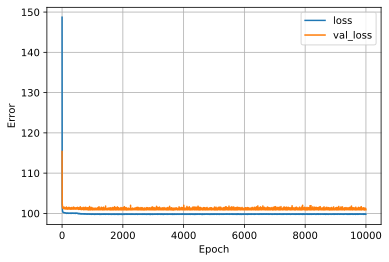

In [725]:
plot_loss(history)

In [726]:
dir(history.history)
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [727]:
labels = list(dataset.columns)
#sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
#sns.pairplot(train_dataset[labels], diag_kind='kde')
print(labels)

['LT(h)', 'dH', 'Ap', 'F107', 'year', 'DOY']


In [728]:
to_predict = X_train_scaled[:2]
# we call the predict method
predictions = model.predict(to_predict)
# print the predictions
print(predictions)
# output
# array([[13.272537], [39.808475]], dtype=float32)
# print the real values
print(y_train[:2])
# array([15.2, 42.3])

[[ 3.6565008]
 [13.730866 ]]
                     Vdrifts
fechas                      
2005-02-20 12:52:30    3.889
2014-08-13 12:02:31   11.170


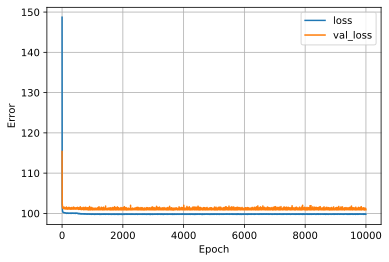

In [729]:
plot_loss(history)

### $\Delta H_{Jicamarca-Piura}$ de las mediciones

In [1099]:
day=23
current_month = 'Agosto-2020'
directory2 = '/home/juanpablo/Desktop-JRO/Magnetometer/%s-Data/Piura/' % current_month
directory1 = '/home/juanpablo/Desktop-JRO/Magnetometer/%s-Data/Jicamarca/' % current_month
directory3 = '/home/juanpablo/Desktop-JRO/Magnetometer/%s-Data/delta-H-%s-Jicamarca-Piura-Data/' % (current_month, current_month)

file2 = 'piur_2008%02d.min' % day
file1 = 'jica_2008%02d.min' % day
file3 = 'dejp_2008%02d.min' % day

magFile_roj = file1
magFile_piura = file2

In [1100]:
file_delta_H = pd.read_csv(directory3 + file3,delimiter=r"\s+", skiprows=2,usecols= ["DD","MM","YYYY", "hh", "mm", "D(deg)","H(nT)","Z(nT)"])
delta_H_medido = GetTimesSeriesH(file_delta_H) 
delta_H_medido.index=delta_H_medido.index-pd.Timedelta(hours=5)
str_date = '%d-%02d-%02d'% (delta_H_medido.index.year[0], delta_H_medido.index.month[0],day)
print(str_date)

2020-08-23


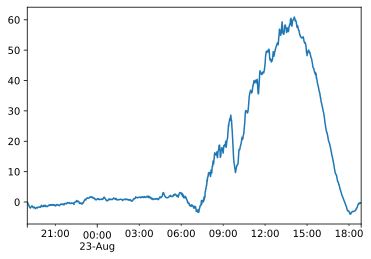

In [1101]:
time_i = datetime.datetime(delta_H_medido.index.year[0], delta_H_medido.index.month[0],delta_H_medido.index.day[0], 10, 0, 0) 
time_f = datetime.datetime(delta_H_medido.index.year[0], delta_H_medido.index.month[0],delta_H_medido.index.day[0], 16, 0, 0) 
#delta_H_medido.reindex(delta_H_medido.index-pd.Timedelta(hours=5))
delta_H_medido.plot()

In [1102]:
print(labels)

['LT(h)', 'dH', 'Ap', 'F107', 'year', 'DOY']


### Ap y F10.7 para Agosto:

In [1103]:
filename_indices = 'ap-f107-agosto-2020.txt'#-%02d.txt' % day
geo_index = pd.read_csv(filename_indices,delim_whitespace=True,header=0,
                     #,skiprows=2,
                 #names=['DD','MM','YYYY','hh','mm','D(deg)','H(nT)','Z(nT)','I(deg)','F(nT)']
                    )

In [1104]:
#geo_index['fecha'] = 
#derivedYear = 1996
#dayOfYear = 32
#import datetime
#d = datetime.datetime.strptime('{} {}'.format(dayOfYear, derivedYear),'%j %Y')
year = geo_index['year'].values
doy = geo_index['doy'].values
hour = geo_index['h'].values
#time_vector = []
date_list = [] # list for datetime objects
datetimeFormat = '%Y-%m-%d %H:%M:%S'
for y, dd,h in zip(year,doy,hour):
    #date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
    #date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
    date = datetime.datetime.strptime('{} {} {}'.format(h,dd, y),'%H %j %Y')
    #time_vector.append(date_string)
    date_list.append(date)
index = pd.DatetimeIndex(date_list) - timedelta(hours=5)
print(index[0], index[-1])
print(min(date_list), max(date_list))
#vpe = np.array(vipe1).T
geo_index.set_index(index,inplace=True, drop=True)


2020-07-31 19:00:00 2020-08-31 18:00:00
2020-08-01 00:00:00 2020-08-31 23:00:00


In [1105]:
geo_index

,year,doy,h,Ap,F107
2020-07-31 19:00:00,2020,214,0,0,74.1
2020-07-31 20:00:00,2020,214,1,0,74.1
2020-07-31 21:00:00,2020,214,2,0,74.1
2020-07-31 22:00:00,2020,214,3,3,74.1
2020-07-31 23:00:00,2020,214,4,3,74.1
...,...,...,...,...,...
2020-08-31 14:00:00,2020,244,19,22,70.5
2020-08-31 15:00:00,2020,244,20,22,70.5
2020-08-31 16:00:00,2020,244,21,15,70.5
2020-08-31 17:00:00,2020,244,22,15,70.5


## Probamos con la data del radar de Agosto del 2020

In [1106]:
current_month = 'Agosto-2020'
directory = '/home/juanpablo/Desktop-JRO/JULIA-processing/hdf5-files-%s/Ecos-150-km' % current_month#hdf5-files-January-2020/'
str_month = 'Agosto'
#day = 1
str_date = '2020-08-%02d' % day
filename ='jul202008%02d_150km.001.hdf5' % day 
ExB_from_function = GetAveragedExBVertical(directory, filename, str_month)

Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/1D Parameters/Data Parameters
Data/Array Layout/1D Parameters/gdlatr
Data/Array Layout/1D Parameters/gdlonr
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dvipe1
Data/Array Layout/2D Parameters/dvipn1
Data/Array Layout/2D Parameters/gdalt
Data/Array Layout/2D Parameters/snl
Data/Array Layout/2D Parameters/vipe1
Data/Array Layout/2D Parameters/vipn1
Data/Array Layout/Layout Description
Data/Array Layout/range
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters
(3994,)
(3994,)


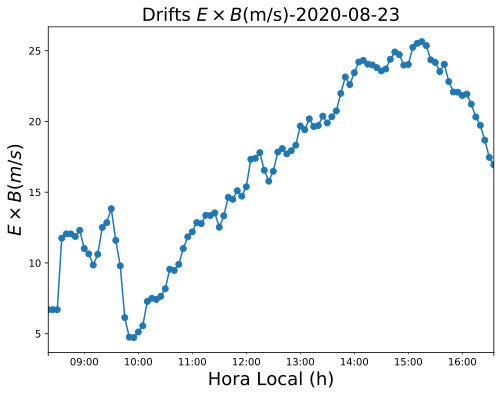

In [1107]:
#ExB_from_function['vipn1'].fillna(ExB_from_function['vipn1'].mean())
#.ffill()
plt.figure(figsize=(8,6))
ExB_from_function['vipn1'].plot(marker='o')
plt.xlabel("Hora Local (h)", fontsize=18)
plt.ylabel(r'$E\times B (m/s)$', fontsize=18)
plt.title(r'Drifts $E\times B$(m/s)-%s'%str_date, fontsize=18)
filename = 'ExB-drifts-%s.png' % str_date
plt.savefig(plots_dir+filename)
#ExB_from_function['vipn1'].loc[hora1:hora2].plot(marker='o')

In [1108]:
hora1 = datetime.datetime(2020, 8,day, 10, 0,0) #- pd.Timedelta(hours=5)
hora7 = datetime.datetime(2020, 8,day, 16, 0, 0) #- pd.Timedelta(hours=5)
print("Number of point for the ExB: ", ExB_from_function['vipn1'].shape)
#hora1= datetime.datetime(2020, 8,int(day_str), 10, 0,0) #- pd.Timedelta(hours=5)
#hora2 = datetime.datetime(2020, 8, int(day_str), 16, 0, 0) #- pd.Timedelta(hours=5)
drifts = ExB_from_function['vipn1']#.ffill()
geo_index.index = geo_index.index - datetime.timedelta(hours=5)
xi = drifts.loc[hora1:hora7]
print(hora1)

Number of point for the ExB:  (100,)
2020-08-23 10:00:00


In [1109]:
geo_index.loc[hora1:hora7]

,year,doy,h,Ap,F107
2020-08-23 10:00:00,2020,236,20,4,72.1
2020-08-23 11:00:00,2020,236,21,12,72.1
2020-08-23 12:00:00,2020,236,22,12,72.1
2020-08-23 13:00:00,2020,236,23,12,72.1
2020-08-23 14:00:00,2020,237,0,3,71.8
2020-08-23 15:00:00,2020,237,1,3,71.8
2020-08-23 16:00:00,2020,237,2,3,71.8


In [1110]:
hora2 = datetime.datetime(2020, 8,ExB_from_function.index.day[0], 11, 0,0) #- pd.Timedelta(hours=5)
hora3 = datetime.datetime(2020, 8,ExB_from_function.index.day[0], 12, 0, 0)
hora4 = datetime.datetime(2020, 8,ExB_from_function.index.day[0], 13, 0, 0)
hora5 = datetime.datetime(2020, 8,ExB_from_function.index.day[0], 14, 0, 0)
hora6 = datetime.datetime(2020, 8,ExB_from_function.index.day[0], 15, 0, 0)
list_horas = [hora1,hora2,hora3,hora4,hora5,hora6,hora7]
dH = []
dH.append(delta_H_medido.loc[hora1])
dH.append(delta_H_medido.loc[hora2])
dH.append(delta_H_medido.loc[hora3])
dH.append(delta_H_medido.loc[hora4])
dH.append(delta_H_medido.loc[hora5])
dH.append(delta_H_medido.loc[hora6])
dH.append(delta_H_medido.loc[hora7])
LT = range(10,17)
print(LT[0])

pred_index = pd.DatetimeIndex(list_horas)
#to_predict = pd.DataFrame()

10


In [1111]:
X_train

,LT(h),dH,Ap,F107,year,DOY
fechas,,,,,,
2005-02-20 12:52:30,12.875,-3.9,15,93.6,2005,51
2014-08-13 12:02:31,12.042,44.8,3,105.6,2014,225
2018-01-12 17:47:31,17.792,20.7,0,68.6,2018,12
2004-01-09 14:42:28,14.708,-94.6,22,114.4,2004,9
2007-11-05 09:42:28,9.708,12.9,0,66.2,2007,309
...,...,...,...,...,...,...
2005-09-13 07:07:30,7.125,-9.8,67,115.0,2005,256
2018-02-02 09:22:30,9.375,7.6,3,66.8,2018,33
2014-03-24 15:42:28,15.708,41.5,3,157.7,2014,83


In [1112]:
print(labels)

['LT(h)', 'dH', 'Ap', 'F107', 'year', 'DOY']


In [1113]:
to_predict = []
ap = geo_index['Ap'].values
F107 = geo_index['F107'].values

for i in range(len(LT)):
    list_temp = [LT[i], dH[i],ap[i],F107[i],year[i], doy[i]]
    to_predict.append(list_temp)
scaler = StandardScaler()
scaler.fit(X_train)

# then we call the transform method to scale both the training and testing data
X_to_predict_scaled = scaler.transform(to_predict)
#X_test_scaled = scaler.transform(X_test)

to_predict = np.array(X_to_predict_scaled)

In [1114]:
#to_predict=to_predict/np.linalg.norm(to_predict)
# we call the predict method
predictions = model.predict(to_predict)
# print the predictions
print(predictions)

[[ 8.86093 ]
 [13.385104]
 [14.608062]
 [16.065323]
 [16.403645]
 [13.160258]
 [ 9.183269]]


In [1115]:
predictions.flatten()

array([ 8.86093 , 13.385104, 14.608062, 16.065323, 16.403645, 13.160258,
        9.183269], dtype=float32)

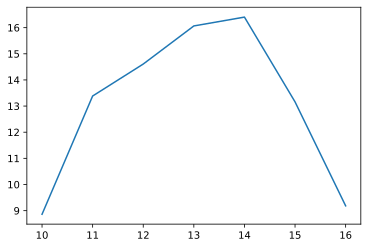

In [1116]:
plt.plot(LT,predictions)
pred_series = pd.Series(predictions.flatten(), index=pred_index)

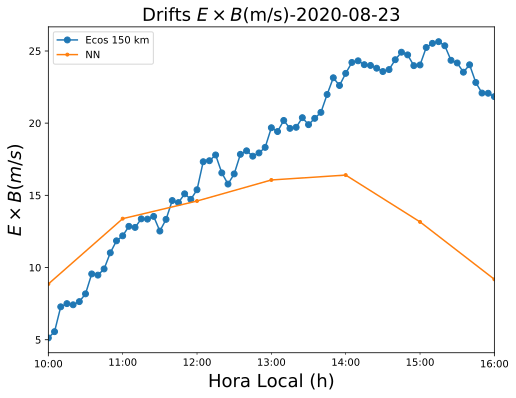

In [1117]:
plt.figure(figsize=(8,6))
ExB_from_function['vipn1'].loc[hora1:hora7].plot(marker='o', label='Ecos 150 km')
pred_series.plot(marker='.', label='NN')
plt.xlabel("Hora Local (h)", fontsize=18)
plt.ylabel(r'$E\times B (m/s)$', fontsize=18)
plt.title(r'Drifts $E\times B$(m/s)-%s'%str_date, fontsize=18)
filename = 'NN-ExB-drifts-comparison-%s-%s.png' % (str_model, str_date)
plt.legend()
plt.savefig(plots_dir+filename)

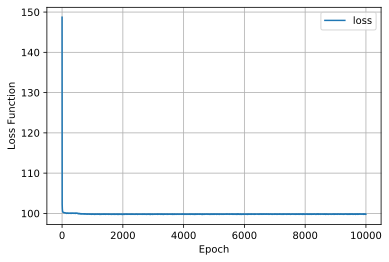

In [1118]:
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()
plt.grid(True)
plt.savefig('loss-function-%s-%s.png' % (str_model, str_date))

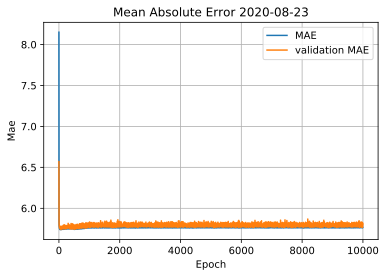

In [1119]:
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='validation MAE')
    #plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.title('Mean Absolute Error %s' %str_date)
plt.ylabel('Mae')
plt.legend()
plt.grid(True)
plt.savefig('mae-%s-%s.png' % (str_model, str_date))